# Neural Network Classification for Customer Purchase Prediction

**Author:** Hemant Thapa  
**Copyright:** @analyticswithharry  
**Python:** 3.10+

This notebook demonstrates how to build a neural network model that predicts whether a customer will purchase a product based on their Age and Annual Salary. We will train a base model, evaluate its performance, tune the hyperparameters to find the best configuration, and compare the results.

---

### Step 1: Import Libraries

We need to import the following:
- **numpy** and **pandas** for data manipulation
- **matplotlib** for creating visualizations
- **nalyst** library components for machine learning (scaling, splitting data, metrics, and neural network classifier)

In [9]:
# importing libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional
from nalyst.transform import StandardScaler
from nalyst.evaluation import train_test_split
from nalyst.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
    )
from nalyst.learners.neural import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [10]:
# defining fixed color scheme and styles
PRIMARY_COLOR = '#1E90FF'
SECONDARY_COLOR = '#00CED1'
ACCENT_COLOR = '#FF6B6B'
TERTIARY_COLOR = '#9370DB'
SUCCESS_COLOR = '#32CD32'
WARNING_COLOR = '#FFD700'
COPYRIGHT_TEXT = '© @analyticswithharry'
plt.style.use('dark_background')

### Step 2: Load the Dataset

We load customer data from a CSV file. This dataset contains information about customers including their User ID, Gender, Age, Annual Salary, and whether they made a purchase (1 = Yes, 0 = No). The output shows the first few rows and the shape of the dataset.

In [11]:
# this function loads the csv and prints a quick preview
def load_dataset(csv_path, preview_rows=5, verbose=True):
    df = pd.read_csv(csv_path)
    preview = df.head(preview_rows)
    if verbose:
        print("Dataset Shape: {}".format(df.shape))
        print(preview)
    return df, {
        "shape": df.shape,
        "preview": preview,
    }

In [12]:
dataset_path = 'Social_Network_Ads.csv'
raw_df, dataset_profile = load_dataset(dataset_path, preview_rows=5, verbose=True)

Dataset Shape: (2000, 5)
    User ID  Gender  Age  EstimatedSalary  Purchased
0  20001801  Female   52            90000          1
1  20001721  Female   26            80000          0
2  20001970  Female   39            71000          0
3  20001960    Male   35            50000          0
4  20001853  Female   35            57000          0


In [13]:
@dataclass
class WorkflowConfig:
    dataset_path: str
    test_size: float = 0.2
    random_state: int = 42
    base_params: Optional[Dict[str, Any]] = None
    tuned_params: Optional[Dict[str, Any]] = None
    hyperparameter_grid: Optional[Dict[str, List[Any]]] = None

    # this method fills in default workflow parameters
    def __post_init__(self):
        if self.base_params is None:
            self.base_params = {
                "hidden_layer_sizes": (128, 64, 32, 16),
                "learning_rate_init": 0.0005,
                "batch_size": 8,
                "max_iter": 5000,
                "alpha": 0.0001,
                "activation": "relu",
                "solver": "adam",
            }
        if self.tuned_params is None:
            self.tuned_params = {
                "hidden_layer_sizes": (16, 8, 4),
                "learning_rate_init": 0.001,
                "batch_size": 32,
                "max_iter": 10000,
                "alpha": 0.0001,
                "activation": "relu",
                "solver": "adam",
            }
        if self.hyperparameter_grid is None:
            self.hyperparameter_grid = {
                "hidden_layer_sizes": [(8, 4), (16, 8, 4), (32, 16, 8, 4)],
                "activation": ["relu", "tanh"],
                "solver": ["adam"],
                "learning_rate_init": [0.0001, 0.001],
                "alpha": [0.0001, 0.001],
                "batch_size": [16, 32],
            }


@dataclass
class WorkflowArtifacts:
    dataset: Optional[pd.DataFrame] = None
    processed_data: Optional[pd.DataFrame] = None
    target_column: Optional[str] = None
    numerical_columns: Optional[List[str]] = None
    scaler: Optional[StandardScaler] = None
    splits: Optional[Dict[str, np.ndarray]] = None
    base_model: Optional[MLPClassifier] = None
    tuned_model: Optional[MLPClassifier] = None
    hyperparameter_summary: Optional[Dict[str, Any]] = None
    base_predictions: Optional[np.ndarray] = None
    tuned_predictions: Optional[np.ndarray] = None
    history: Optional[Dict[str, List[float]]] = None

In [14]:
# this method runs the full purchase workflow with optional extras
def run_full_workflow(self, run_visuals: bool = False, run_advanced: bool = False, verbose: bool = True) -> Dict[str, Any]:
        self.load_and_profile(verbose=verbose)
        prepared = self.prepare_features(verbose=verbose)
        self.split_data(prepared["features"], prepared["target"], verbose=verbose)
        base_metrics = self.train_base_model(verbose=verbose)
        loss_history = self.run_loss_tracking()
        hyper_summary = self.optimize_hyperparameters(verbose=verbose)
        self.train_tuned_model(verbose=verbose)
        tuned_metrics = self.evaluate_tuned_model(verbose=verbose)
        visuals = self.build_visual_report() if run_visuals else {}
        advanced = self.run_advanced_analysis() if run_advanced else {}
        return {
            "metadata": self.metadata,
            "loss_history": loss_history,
            "hyperparameter_summary": hyper_summary,
            "base_metrics": base_metrics,
            "tuned_metrics": tuned_metrics,
            "visualizations": visuals,
            "advanced_analysis": advanced,
        }

In [15]:
# this helper wires up the workflow with overrides
def execute_purchase_workflow(dataset_path: str, run_visuals: bool = False, run_advanced: bool = False, **overrides) -> Dict[str, Any]:
    config = WorkflowConfig(dataset_path=dataset_path, **overrides)
    workflow = NeuralPurchaseWorkflow(config)
    return workflow.run_full_workflow(run_visuals=run_visuals, run_advanced=run_advanced)

### Step 3: Explore the Data

Before building a model, we check the data quality. We look for missing values (empty cells) and understand the data types. This helps us identify any data cleaning needed before training.

In [16]:
# this function summarizes missing data and duplicates
def summarize_dataset_health(df, verbose=True):
    missing_values = df.isnull().sum()
    if verbose:
        print("Missing Values:")
        print(missing_values)
    return missing_values

In [17]:
missing_values_summary = summarize_dataset_health(raw_df)

Missing Values:
User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64


In [18]:
# this function reports column types and basic schema info
def summarize_dataset_schema(df, verbose=True):
    dtype_info = df.dtypes
    stats_summary = df.describe(include="all")
    if verbose:
        print("\nData Types:")
        print(dtype_info)
        print("\nStatistical Summary:")
        print(stats_summary)
    return {
        "dtypes": dtype_info,
        "stats": stats_summary,
    }

In [19]:
schema_summary = summarize_dataset_schema(raw_df)


Data Types:
User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

Statistical Summary:
             User ID  Gender          Age  EstimatedSalary    Purchased
count   2.000000e+03    2000  2000.000000      2000.000000  2000.000000
unique           NaN       2          NaN              NaN          NaN
top              NaN  Female          NaN              NaN          NaN
freq             NaN    1038          NaN              NaN          NaN
mean    2.000170e+07     NaN    38.070500     69672.500000     0.368500
std     2.825342e+02     NaN    10.442129     33793.227648     0.482519
min     2.000027e+07     NaN    18.000000     15000.000000     0.000000
25%     2.000158e+07     NaN    30.000000     43000.000000     0.000000
50%     2.000178e+07     NaN    37.500000     70000.000000     0.000000
75%     2.000191e+07     NaN    46.000000     87000.000000     1.000000
max     2.000200e+07     NaN 

The statistical summary shows the distribution of numerical values including count, mean, standard deviation, minimum, maximum, and quartiles (25%, 50%, 75%).

In [20]:
# this function builds descriptive stats for numeric columns
def compute_statistical_summary(df, verbose=True):
    summary = df.describe(include="all")
    if verbose:
        print("Statistical Summary:")
        print(summary)
    return summary

In [21]:
statistical_summary = compute_statistical_summary(raw_df)

Statistical Summary:
             User ID  Gender          Age  EstimatedSalary    Purchased
count   2.000000e+03    2000  2000.000000      2000.000000  2000.000000
unique           NaN       2          NaN              NaN          NaN
top              NaN  Female          NaN              NaN          NaN
freq             NaN    1038          NaN              NaN          NaN
mean    2.000170e+07     NaN    38.070500     69672.500000     0.368500
std     2.825342e+02     NaN    10.442129     33793.227648     0.482519
min     2.000027e+07     NaN    18.000000     15000.000000     0.000000
25%     2.000158e+07     NaN    30.000000     43000.000000     0.000000
50%     2.000178e+07     NaN    37.500000     70000.000000     0.000000
75%     2.000191e+07     NaN    46.000000     87000.000000     1.000000
max     2.000200e+07     NaN    60.000000    150000.000000     1.000000


### Step 4: Automatic Feature and Target Selection

The code automatically analyzes the dataset to identify:
- **Target variable:** Binary column (0/1 values) typically representing the outcome to predict
- **Feature variables:** Numeric columns suitable for model input (excluding IDs and target)

This makes the notebook work with any similar dataset without manual column name changes.

In [22]:
# automatic column detection function
# this function tries to auto tag features and targets
def auto_detect_columns(dataframe, verbose=True):
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    
    target_col = None
    feature_cols = []
    id_cols = []
    
    n_rows = len(dataframe)
    
    for col in numeric_cols:
        unique_vals = dataframe[col].unique()
        n_unique = len(unique_vals)
        col_data = dataframe[col].dropna().values
        is_id_column = False

        if np.all(col_data == col_data.astype(int)):
            mean_val = np.mean(col_data)
            min_val = np.min(col_data)
            max_val = np.max(col_data)
            std_val = np.std(col_data)
            
            if mean_val > 100000 and std_val / mean_val < 0.1:
                is_id_column = True
            elif n_unique / n_rows > 0.5:
                sorted_vals = np.sort(col_data)
                diffs = np.diff(sorted_vals)
                if len(diffs) > 0:
                    median_diff = np.median(diffs)
                    if median_diff > 0 and np.std(diffs) / median_diff < 2:
                        is_id_column = True
        
        if is_id_column:
            id_cols.append(col)
            continue
        if n_unique == 2 and set(unique_vals).issubset({0, 1}):
            if target_col is None:
                target_col = col
            continue
        feature_cols.append(col)

    if target_col is None:
        remaining = [c for c in numeric_cols if c not in id_cols]
        if remaining:
            target_col = remaining[-1]
            feature_cols = [c for c in remaining if c != target_col]
            if verbose:
                print("Warning: No binary target found, using last numeric column")
    feature_cols = [c for c in feature_cols if c != target_col and c not in id_cols]
    
    X = dataframe[feature_cols].values
    y = dataframe[target_col].values
    
    if verbose:
        print("Column Selected")
        if id_cols:
            print("ID Columns (excluded): {}".format(id_cols))
        print("Target Column:         {}".format(target_col))
        print("Feature Columns:       {}".format(feature_cols))
        print("\nFeatures shape: {}".format(X.shape))
        print("Target shape:   {}".format(y.shape))
        print("Class distribution: {}".format(np.bincount(y.astype(int))))
    
    return X, y, feature_cols, target_col

In [23]:
# this function finalizes feature and target selections
def detect_features_and_target(df, verbose=True):
    X, y, feature_cols, target_col = auto_detect_columns(df, verbose=verbose)
    return {
        "features": X,
        "target": y,
        "feature_names": feature_cols,
        "target_column": target_col,
    }

In [24]:
feature_detection = detect_features_and_target(raw_df)
X_raw = feature_detection["features"]
y_raw = feature_detection["target"]
feature_names = feature_detection["feature_names"]
target_column = feature_detection["target_column"]

Column Selected
ID Columns (excluded): ['User ID']
Target Column:         Purchased
Feature Columns:       ['Age', 'EstimatedSalary']

Features shape: (2000, 2)
Target shape:   (2000,)
Class distribution: [1263  737]


### Step 5: Scale the Features

Neural networks work better when features are on a similar scale. Age ranges from ~18-60 while Salary ranges from ~15,000-150,000. We use **StandardScaler** to transform both features to have mean=0 and standard deviation=1. This helps the neural network learn more efficiently.

In [25]:
# this function fits or applies the scaler to features
def scale_features(X, scaler=None, verbose=True):
    scaler = scaler or StandardScaler()
    scaler.train(X)
    X_scaled = scaler.transform(X)
    if verbose:
        print("Before scaling:")
        print("  Feature 1 - Mean: {:.2f}, Std: {:.2f}".format(X[:, 0].mean(), X[:, 0].std()))
        print("  Feature 2 - Mean: {:.2f}, Std: {:.2f}".format(X[:, 1].mean(), X[:, 1].std()))
        print("\nAfter scaling:")
        print("  Feature 1 - Mean: {:.6f}, Std: {:.2f}".format(X_scaled[:, 0].mean(), X_scaled[:, 0].std()))
        print("  Feature 2 - Mean: {:.6f}, Std: {:.2f}".format(X_scaled[:, 1].mean(), X_scaled[:, 1].std()))
    return scaler, X_scaled

In [26]:
scaler, X_scaled = scale_features(X_raw)

Before scaling:
  Feature 1 - Mean: 38.07, Std: 10.44
  Feature 2 - Mean: 69672.50, Std: 33784.78

After scaling:
  Feature 1 - Mean: -0.000000, Std: 1.00
  Feature 2 - Mean: -0.000000, Std: 1.00


### Step 6: Split Data into Training and Test Sets

We divide the data into two parts:
- **Training Set (80%)**: Used to teach the model patterns in the data
- **Test Set (20%)**: Used to evaluate how well the model performs on new, unseen data

We use stratified sampling to ensure both sets have similar proportions of purchases and non-purchases.

In [27]:
# this function performs a stratified train test split
def stratified_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

In [28]:
X_train, X_test, y_train, y_test = stratified_split(X_scaled, y_raw, test_size=0.2, random_state=42)

In [29]:
# this function prints class balance for the splits
def describe_split(y_train, y_test, verbose=True):
    train_dist = np.bincount(y_train)
    test_dist = np.bincount(y_test)
    if verbose:
        print("Training set size: {}".format(y_train.shape[0]))
        print("Test set size: {}".format(y_test.shape[0]))
        print("Training class distribution: {}".format(train_dist))
        print("Test class distribution: {}".format(test_dist))
    return {
        "train_distribution": train_dist,
        "test_distribution": test_dist,
    }

In [30]:
split_distribution = describe_split(y_train, y_test)

Training set size: 1601
Test set size: 399
Training class distribution: [1011  590]
Test class distribution: [252 147]


### Step 7: Build the Neural Network Model

A neural network is a machine learning model inspired by the human brain. It consists of layers of connected neurons that learn patterns from data.

**Our Network Architecture:**
- **Input Layer:** 2 neurons (one for Age, one for Salary)
- **Hidden Layers:** 128, 64, 32, and 16 neurons that process the information
- **Output Layer:** 1 neuron that gives the probability of purchase

**Key Parameters:**
- **Activation (ReLU):** A function that helps the network learn complex patterns. Formula: f(x) = max(0, x)
- **Learning Rate (0.0005):** How fast the model adjusts during training. Lower values mean slower but more stable learning.
- **Max Iterations (10000):** Maximum number of times the model will go through the training data
- **Batch Size (8):** Number of samples processed before updating the model weights

In [31]:
# this function builds the baseline mlp classifier
def build_base_mlp(hidden_layer_sizes=(128, 64, 32, 16), learning_rate_init=0.0005, batch_size=8, max_iter=5000):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        batch_size=batch_size,
        alpha=0.0001,
        random_state=42,
        verbose=True,
    )
    print("Base Neural Network Architecture:")
    print("Input Layer:    {} neurons (features)".format(hidden_layer_sizes[0]))
    for idx, units in enumerate(hidden_layer_sizes, start=1):
        print("Hidden Layer {}: {} neurons (ReLU)".format(idx, units))
    print("Output Layer:   1 neuron (Sigmoid)")
    print("Max Iterations: {}".format(max_iter))
    return model

In [32]:
base_model = build_base_mlp()

Base Neural Network Architecture:
Input Layer:    128 neurons (features)
Hidden Layer 1: 128 neurons (ReLU)
Hidden Layer 2: 64 neurons (ReLU)
Hidden Layer 3: 32 neurons (ReLU)
Hidden Layer 4: 16 neurons (ReLU)
Output Layer:   1 neuron (Sigmoid)
Max Iterations: 5000


### Step 8: Train the Model

Training is the process where the model learns from the data. During training:
1. The model makes predictions on training data
2. It compares predictions to actual values and calculates error (loss)
3. It adjusts its internal weights to reduce this error
4. This process repeats for 10,000 iterations

The training accuracy tells us how well the model learned from the training data.

In [33]:
# this function trains the provided model and echoes progress
def train_model(model, X_train, y_train, verbose=True):
    if verbose:
        print("Training Neural Network...")
    model.train(X_train, y_train)
    return model

In [34]:
base_model = train_model(base_model, X_train, y_train)

Training Neural Network...
Iteration 1, loss = 0.26100678
Iteration 2, loss = 0.24315807
Iteration 3, loss = 0.23804827
Iteration 4, loss = 0.23572640
Iteration 5, loss = 0.23390405
Iteration 6, loss = 0.23285322
Iteration 7, loss = 0.23115037
Iteration 8, loss = 0.23008538
Iteration 9, loss = 0.22933312
Iteration 10, loss = 0.22902732
Iteration 11, loss = 0.22739131
Iteration 12, loss = 0.22658847
Iteration 13, loss = 0.22602164
Iteration 14, loss = 0.22533544
Iteration 15, loss = 0.22501507
Iteration 16, loss = 0.22444703
Iteration 17, loss = 0.22349864
Iteration 18, loss = 0.22297607
Iteration 19, loss = 0.22259611
Iteration 20, loss = 0.22154478
Iteration 21, loss = 0.22090926
Iteration 22, loss = 0.22045983
Iteration 23, loss = 0.21991530
Iteration 24, loss = 0.21945584
Iteration 25, loss = 0.21897032
Iteration 26, loss = 0.21848048
Iteration 27, loss = 0.21794399
Iteration 28, loss = 0.21752845
Iteration 29, loss = 0.21670255
Iteration 30, loss = 0.21636236
Iteration 31, loss = 0

In [35]:
# this function computes accuracy on supplied data
def evaluate_accuracy(model, X, y, label="Training"):
    predictions = model.infer(X)
    score = accuracy_score(y, predictions)
    print("{} Accuracy: {:.2f}%".format(label, score * 100))
    return score, predictions

In [36]:
base_train_accuracy, base_train_predictions = evaluate_accuracy(base_model, X_train, y_train, label="Base · Train")
base_test_accuracy, base_test_predictions = evaluate_accuracy(base_model, X_test, y_test, label="Base · Test")
base_test_probabilities = base_model.infer_proba(X_test)[:, 1]

Base · Train Accuracy: 94.50%
Base · Test Accuracy: 93.73%


### Step 9: Visualize Training Progress

The loss curve shows how the model's error changes during training:
- **Training Loss (Blue):** Error on training data - should decrease over time
- **Test Loss (Red):** Error on unseen test data - helps detect overfitting

If test loss starts increasing while training loss keeps decreasing, the model is memorizing training data instead of learning general patterns (overfitting).

In [37]:
from nalyst.metrics import log_loss

In [38]:

# this function records train and validation loss curves
def track_loss_curves(
    X_train,
    y_train,
    X_test,
    y_test,
    checkpoints=None,
    model_config=None,
    verbose=True,
):
    iterations_checkpoints = checkpoints or list(range(250, 5001, 250))
    base_config = {
        "hidden_layer_sizes": (128, 64, 32, 16),
        "activation": "relu",
        "solver": "adam",
        "learning_rate_init": 0.0005,
        "max_iter": 250,
        "batch_size": 8,
        "alpha": 0.0001,
        "random_state": 42,
        "verbose": False,
        "warm_start": True,
    }
    if model_config:
        base_config.update(model_config)

    track_model = MLPClassifier(**base_config)
    train_losses = []
    test_losses = []
    prev_iter = 0

    if verbose:
        print(
            "Calculating Train and Test Losses at {} checkpoints...".format(
                len(iterations_checkpoints)
            )
        )
        print("-" * 50)

    for i, n_iter in enumerate(iterations_checkpoints):
        step_iters = max(n_iter - prev_iter, 1)
        track_model.max_iter = step_iters
        track_model.train(X_train, y_train)
        prev_iter = n_iter

        train_proba = track_model.infer_proba(X_train)[:, 1]
        test_proba = track_model.infer_proba(X_test)[:, 1]

        train_loss = log_loss(y_train, train_proba)
        test_loss = log_loss(y_test, test_proba)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if verbose and (i + 1) % 10 == 0:
            print(
                "Iteration {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(
                    n_iter, train_loss, test_loss
                )
            )

    min_train_idx = int(np.argmin(train_losses))
    min_test_idx = int(np.argmin(test_losses))

    if verbose:
        print("-" * 50)
        print("Loss calculation complete!")
        print(
            "Final Train Loss: {:.4f}, Final Test Loss: {:.4f}".format(
                train_losses[-1], test_losses[-1]
            )
        )
        print(
            "Best Test Loss: {:.4f} at iteration {}".format(
                test_losses[min_test_idx], iterations_checkpoints[min_test_idx]
            )
        )

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    ax1 = axes[0]
    ax1.plot(
        iterations_checkpoints,
        train_losses,
        color=PRIMARY_COLOR,
        lw=2,
        marker="o",
        markersize=4,
        label="Training Loss",
    )
    ax1.fill_between(
        iterations_checkpoints, train_losses, alpha=0.2, color=PRIMARY_COLOR
    )
    ax1.scatter(
        [iterations_checkpoints[min_train_idx]],
        [train_losses[min_train_idx]],
        color=SUCCESS_COLOR,
        s=120,
        zorder=5,
        edgecolor="white",
        linewidth=2,
    )
    ax1.annotate(
        "Min: {:.4f}".format(train_losses[min_train_idx]),
        xy=(iterations_checkpoints[min_train_idx], train_losses[min_train_idx]),
        xytext=(
            iterations_checkpoints[min_train_idx] - 1500,
            train_losses[min_train_idx] - 0.015,
        ),
        fontsize=11,
        color=SUCCESS_COLOR,
        fontweight="bold",
        arrowprops=dict(arrowstyle="->", color=SUCCESS_COLOR, lw=1.5),
    )
    ax1.set_xlabel("Iterations", fontsize=14, color="white")
    ax1.set_ylabel("Loss (Binary Cross-Entropy)", fontsize=14, color="white")
    ax1.set_xlim(0, 10500)
    ax1.set_xticks(range(0, 11000, 1000))
    ax1.tick_params(axis="both", labelcolor="white", labelsize=11)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_color("white")
    ax1.spines["bottom"].set_color("white")
    ax1.set_facecolor("black")
    ax1.set_title(
        "Training Loss ({} Checkpoints)".format(len(iterations_checkpoints)),
        fontsize=16,
        color="white",
        fontweight="bold",
        pad=15,
    )
    ax1.legend(
        loc="upper right",
        fontsize=11,
        facecolor="black",
        edgecolor="white",
        labelcolor="white",
    )
    ax1.grid(True, ls="--", alpha=0.3, color="white")

    ax2 = axes[1]
    ax2.plot(
        iterations_checkpoints,
        test_losses,
        color=ACCENT_COLOR,
        lw=2,
        marker="s",
        markersize=4,
        label="Test Loss",
    )
    ax2.fill_between(
        iterations_checkpoints, test_losses, alpha=0.2, color=ACCENT_COLOR
    )
    ax2.scatter(
        [iterations_checkpoints[min_test_idx]],
        [test_losses[min_test_idx]],
        color=SUCCESS_COLOR,
        s=120,
        zorder=5,
        edgecolor="white",
        linewidth=2,
    )
    ax2.annotate(
        "Min: {:.4f}".format(test_losses[min_test_idx]),
        xy=(iterations_checkpoints[min_test_idx], test_losses[min_test_idx]),
        xytext=(
            iterations_checkpoints[min_test_idx] + 1000,
            test_losses[min_test_idx] - 0.015,
        ),
        fontsize=11,
        color=SUCCESS_COLOR,
        fontweight="bold",
        arrowprops=dict(arrowstyle="->", color=SUCCESS_COLOR, lw=1.5),
    )
    ax2.set_xlabel("Iterations", fontsize=14, color="white")
    ax2.set_ylabel("Loss (Binary Cross-Entropy)", fontsize=14, color="white")
    ax2.set_xlim(0, 10500)
    ax2.set_xticks(range(0, 11000, 1000))
    ax2.tick_params(axis="both", labelcolor="white", labelsize=11)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_color("white")
    ax2.spines["bottom"].set_color("white")
    ax2.set_facecolor("black")
    ax2.set_title(
        "Test Loss ({} Checkpoints)".format(len(iterations_checkpoints)),
        fontsize=16,
        color="white",
        fontweight="bold",
        pad=15,
    )
    ax2.legend(
        loc="upper right",
        fontsize=11,
        facecolor="black",
        edgecolor="white",
        labelcolor="white",
    )
    ax2.grid(True, ls="--", alpha=0.3, color="white")

    fig.patch.set_facecolor("black")
    plt.figtext(
        0.95,
        0.01,
        COPYRIGHT_TEXT,
        ha="right",
        va="bottom",
        fontsize=12,
        color="white",
        alpha=0.9,
    )
    fig.tight_layout()
    plt.show()

    return {
        "model": track_model,
        "iterations": iterations_checkpoints,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "best_test_loss": test_losses[min_test_idx],
        "best_test_iteration": iterations_checkpoints[min_test_idx],
        "figure": fig,
    }

In [39]:
# this function gathers loss tracking artifacts
def compute_loss_tracking_summary(X_train, y_train, X_test, y_test, **kwargs):
    return track_loss_curves(X_train, y_train, X_test, y_test, **kwargs)

Calculating Train and Test Losses at 20 checkpoints...
--------------------------------------------------
Iteration 2500: Train Loss = 0.0562, Test Loss = 0.0786
Iteration 5000: Train Loss = 0.0437, Test Loss = 0.0603
--------------------------------------------------
Loss calculation complete!
Final Train Loss: 0.0437, Final Test Loss: 0.0603
Best Test Loss: 0.0603 at iteration 5000


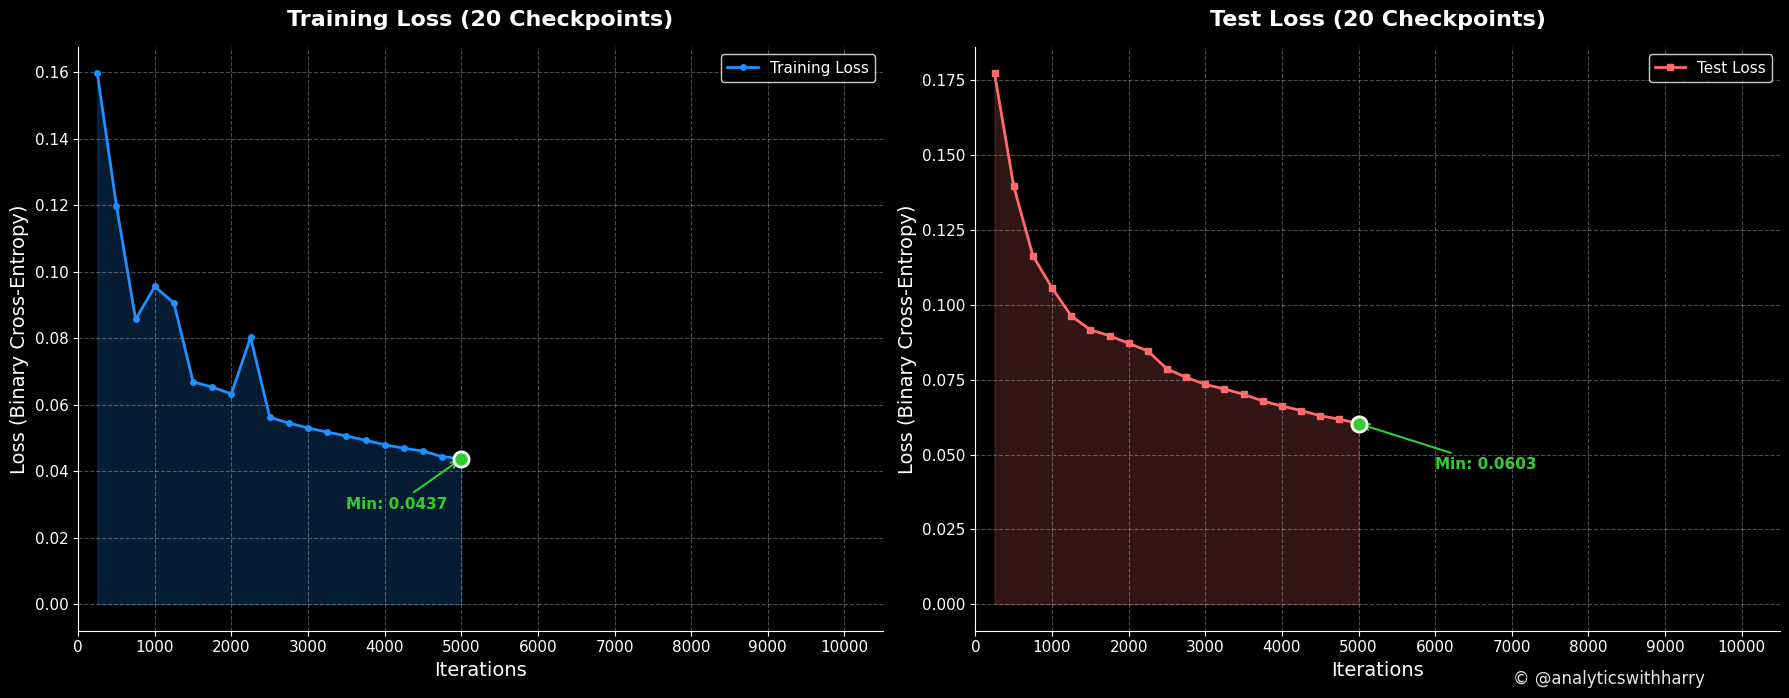

In [40]:
loss_tracking_summary = compute_loss_tracking_summary(X_train, y_train, X_test, y_test)

### Step 10: Make Predictions

Now we use the trained model to predict on the test data (data the model has never seen). We compare predictions to actual values to see how many the model got right and wrong.

In [41]:
# this function returns class predictions and probabilities
def generate_predictions(model, X, y_true=None, verbose=True):
    preds = model.infer(X)
    probas = model.infer_proba(X)[:, 1] if hasattr(model, "infer_proba") else None
    if verbose and y_true is not None:
        print("Prediction Results:")
        print("Samples: {}".format(len(X)))
        print("Correct predictions: {}".format((preds == y_true).sum()))
        print("Incorrect predictions: {}".format((preds != y_true).sum()))
        print("Test Accuracy: {:.2f}%".format((preds == y_true).mean() * 100))
    return preds, probas

In [42]:
base_predictions, base_probabilities = generate_predictions(base_model, X_test, y_true=y_test)

Prediction Results:
Samples: 399
Correct predictions: 374
Incorrect predictions: 25
Test Accuracy: 93.73%


### Step 11: Confusion Matrix

A confusion matrix shows the breakdown of predictions:
- **True Positive (TP):** Correctly predicted as "Purchased"
- **True Negative (TN):** Correctly predicted as "Not Purchased"  
- **False Positive (FP):** Incorrectly predicted as "Purchased" (Type I error)
- **False Negative (FN):** Incorrectly predicted as "Not Purchased" (Type II error)

This helps us understand what types of mistakes the model makes.

In [43]:
# confusion matrix and classification report 
# this function draws the confusion matrix panels
def plot_confusion_matrix_dashboard(
    y_true,
    y_pred,
    class_labels=None,
    figsize=(15, 6),
    cmap="Blues",
    show_report=True,
):
    class_labels = class_labels or ["Class 0", "Class 1"]
    cm = confusion_matrix(y_true, y_pred)

    metrics_dict = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        output_dict=True,
    )
    report_text = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        digits=3,
    )

    accuracy_pct = metrics_dict["accuracy"]["f1-score"] * 100
    macro_f1 = metrics_dict["macro avg"]["f1-score"]
    weighted_f1 = metrics_dict["weighted avg"]["f1-score"]

    # this helper wraps long labels for readability
    def _wrap_label(name):
        if len(name) <= 18:
            return name
        if "(" in name:
            base, rest = name.split("(", 1)
            return f"{base.strip()}\n({rest}"
        return "\n".join(name.split())

    wrapped_labels = [_wrap_label(lbl) for lbl in class_labels]

    with plt.style.context("dark_background"):
        fig = plt.figure(figsize=figsize, constrained_layout=False)
        grid = fig.add_gridspec(1, 2, width_ratios=[1.4, 0.9], wspace=0.15)

        ax = fig.add_subplot(grid[0])
        im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("Count", rotation=-90, va="bottom", fontsize=12, color="white")
        cbar.ax.tick_params(labelsize=10, colors="white")

        tick_positions = np.arange(cm.shape[0])
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels(wrapped_labels, fontsize=12, rotation=35, ha="right")
        ax.set_yticklabels(wrapped_labels, fontsize=12)
        ax.set_ylabel("True Label", fontsize=14, color=PRIMARY_COLOR)
        ax.set_xlabel("Predicted Label", fontsize=14, color=SECONDARY_COLOR)

        ax.tick_params(axis="both", labelcolor="white", labelsize=11, length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color("#555555")
        ax.spines["bottom"].set_color("#555555")

        thresh = cm.max() / 2 if cm.size else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                cell_value = cm[i, j]
                ax.text(
                    j,
                    i,
                    f"{cell_value:,}",
                    ha="center",
                    va="center",
                    fontsize=14,
                    fontweight="bold",
                    color="white" if cell_value > thresh else "#0b0b0f",
                    bbox=dict(boxstyle="round,pad=0.25", facecolor="black", alpha=0.25),
                )

        ax.set_title(
            "Confusion Matrix\nNeural Network Classification",
            fontsize=18,
            color="white",
            pad=16,
        )

        summary_ax = fig.add_subplot(grid[1])
        summary_ax.set_facecolor("#080808")
        summary_ax.set_xlim(0, 1)
        summary_ax.set_ylim(0, 1)
        summary_ax.axis("off")

        summary_ax.text(
            0.5,
            0.94,
            "Performance Summary",
            ha="center",
            fontsize=17,
            color="white",
            fontweight="bold",
        )

        summary_stats = [
            ("Accuracy", f"{accuracy_pct:.2f}%"),
            ("Macro F1", f"{macro_f1:.3f}"),
            ("Weighted F1", f"{weighted_f1:.3f}"),
        ]

        y_cursor = 0.83
        for label, value in summary_stats:
            summary_ax.text(
                0.08,
                y_cursor,
                label,
                fontsize=13,
                color=ACCENT_COLOR,
                fontweight="bold",
            )
            summary_ax.text(
                0.92,
                y_cursor,
                value,
                fontsize=13,
                color="white",
                fontweight="bold",
                ha="right",
            )
            y_cursor -= 0.09

        table_cols = ["Class", "Precision", "Recall", "F1", "Support"]
        table_data = [
            [
                _wrap_label(name),
                f"{metrics_dict[name]['precision']:.2f}",
                f"{metrics_dict[name]['recall']:.2f}",
                f"{metrics_dict[name]['f1-score']:.2f}",
                f"{metrics_dict[name]['support']}",
            ]
            for name in class_labels
        ]

        table = summary_ax.table(
            cellText=table_data,
            colLabels=table_cols,
            loc="lower center",
            cellLoc="center",
            colLoc="center",
            bbox=[0.02, 0.05, 0.96, 0.55],
        )
        table.auto_set_font_size(False)
        table.set_fontsize(11)

        for (row, col), cell in table.get_celld().items():
            cell.set_edgecolor("#222222")
            cell.set_facecolor("#101010" if row == 0 else "#151515")
            cell.get_text().set_color("white")
            if row == 0:
                cell.get_text().set_fontweight("bold")

        fig.text(
            0.96,
            0.015,
            COPYRIGHT_TEXT,
            ha="right",
            va="bottom",
            fontsize=11,
            color="white",
            alpha=0.8,
        )

        fig.patch.set_facecolor("black")
        fig.tight_layout(rect=[0.01, 0.02, 0.97, 0.98])
        plt.show()

    if show_report:
        print("\nClassification Report")
        print("=" * 70)
        print(report_text)

    return {
        "matrix": cm,
        "report": report_text,
        "metrics": metrics_dict,
        "figure": fig,
    }

In [44]:
# this function packages confusion stats and figure
def generate_confusion_dashboard(y_true, y_pred, labels):
    return plot_confusion_matrix_dashboard(y_true, y_pred, class_labels=labels)

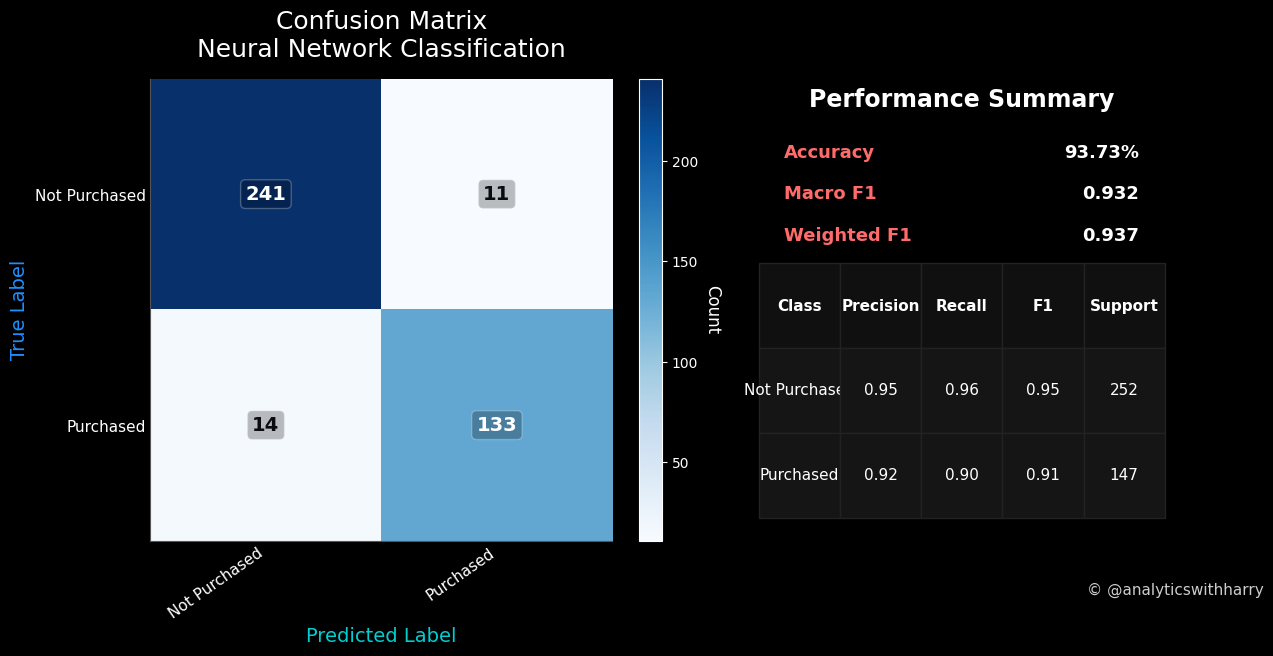


Classification Report
                 precision     recall   f1-score    support

Not Purchased        0.945      0.956      0.951        252
Purchased            0.924      0.905      0.914        147

accuracy                                   0.937        399
macro avg            0.934      0.931      0.932        399
weighted avg         0.937      0.937      0.937        399


In [45]:
confusion_dashboard = generate_confusion_dashboard(y_test, base_predictions, ["Not Purchased", "Purchased"])

### Step 12: Decision Boundary Visualization

The decision boundary shows how the model divides the feature space into regions. Points on one side are classified as "Purchased" and on the other side as "Not Purchased". This visualization helps understand what patterns the model learned.

In [46]:
# this function visualizes decision boundaries per split
def plot_decision_boundary_panels(model, X_train, y_train, X_test, y_test, feature_labels=None, figsize=(16, 6)):
    feature_labels = feature_labels or ["Feature 1", "Feature 2"]
    # this helper draws the filled decision boundary
    def _plot_decision_boundary(ax, X, y, title):
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = model.infer(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        custom_cmap = LinearSegmentedColormap.from_list("custom", [SECONDARY_COLOR, PRIMARY_COLOR])
        ax.contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
        ax.contour(xx, yy, Z, colors="white", linewidths=0.8, alpha=0.8)
        ax.scatter(
            X[y == 0, 0], X[y == 0, 1],
            c=SECONDARY_COLOR, edgecolors="white", s=60, alpha=0.85, label="Not Purchased"
        )
        ax.scatter(
            X[y == 1, 0], X[y == 1, 1],
            c=PRIMARY_COLOR, edgecolors="white", s=60, alpha=0.85, label="Purchased"
        )
        ax.set_xlabel(f"{feature_labels[0]} (Standardized)", fontsize=14, color="white")
        ax.set_ylabel(f"{feature_labels[1]} (Standardized)", fontsize=14, color="white")
        ax.set_title(title, fontsize=16, color="white", pad=12)
        ax.tick_params(axis="both", labelcolor="white", labelsize=12)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(fontsize=10, loc="upper right")
    with plt.style.context("dark_background"):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        _plot_decision_boundary(axes[0], X_train, y_train, "Decision Boundary · Train")
        _plot_decision_boundary(axes[1], X_test, y_test, "Decision Boundary · Test")
        fig.text(0.95, 0.0001, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=12, color="white", alpha=0.9)
        fig.tight_layout()
        plt.show()
    return fig

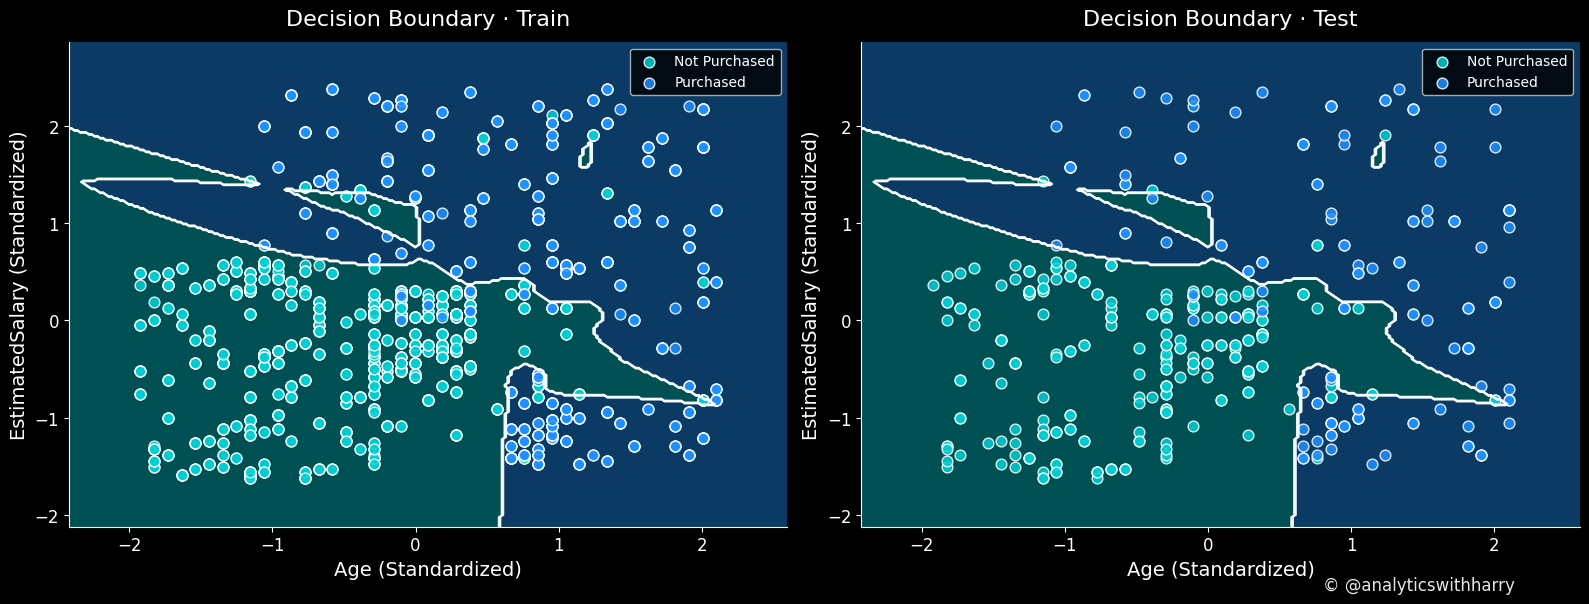

In [47]:
decision_boundary_plot = plot_decision_boundary_panels(base_model, X_train, y_train, X_test, y_test, feature_labels=feature_names)

### Step 13: ROC Curve and AUC Score

The ROC (Receiver Operating Characteristic) curve shows the trade-off between:
- **True Positive Rate (TPR):** Percentage of actual purchases correctly identified
- **False Positive Rate (FPR):** Percentage of non-purchases incorrectly classified as purchases

**AUC (Area Under Curve):** A score between 0 and 1. Higher is better:
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random guessing
- AUC > 0.8: Good classifier

In [48]:
# this function computes roc curve coordinates
def compute_roc_curve_points(y_true_vals, y_score_vals):
    sorted_indices = np.argsort(y_score_vals)[::-1]
    y_true_sorted = np.array(y_true_vals)[sorted_indices]
    y_score_sorted = np.array(y_score_vals)[sorted_indices]
    thresholds = np.unique(y_score_sorted)
    thresholds = np.concatenate([[thresholds[0] + 1], thresholds]) if len(thresholds) else np.array([1])
    tpr_list, fpr_list = [], []
    n_pos = np.sum(y_true_vals == 1)
    n_neg = np.sum(y_true_vals == 0)
    for thresh in thresholds:
        y_pred_thresh = (y_score_vals >= thresh).astype(int)
        tp = np.sum((y_pred_thresh == 1) & (y_true_vals == 1))
        fp = np.sum((y_pred_thresh == 1) & (y_true_vals == 0))
        tpr_list.append(tp / n_pos if n_pos > 0 else 0)
        fpr_list.append(fp / n_neg if n_neg > 0 else 0)
    return np.array(fpr_list), np.array(tpr_list), thresholds

# this function plots roc curves and thresholds
def plot_roc_curve_dashboard(y_true, y_score, figsize=(10, 6)):
    if y_score is None:
        raise ValueError("y_score must contain probability estimates for ROC curve")
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(figsize=figsize)
        fpr, tpr, thresholds = compute_roc_curve_points(y_true, y_score)
        roc_auc = roc_auc_score(y_true, y_score)
        ax.plot(fpr, tpr, color=PRIMARY_COLOR, lw=1.5, label="ROC Curve")
        ax.fill_between(fpr, tpr, alpha=0.2, color=PRIMARY_COLOR)
        ax.plot([0, 1], [0, 1], color=ACCENT_COLOR, lw=1.5, linestyle="--", label="Random Classifier", alpha=0.8)
        ax.text(0.65, 0.25, f"AUC = {roc_auc:.4f}", va="center", color=PRIMARY_COLOR, fontsize=14, bbox=dict(facecolor="black", edgecolor=PRIMARY_COLOR, boxstyle="round,pad=0.3"))
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate", fontsize=14, color="white")
        ax.set_ylabel("True Positive Rate", fontsize=16, color=PRIMARY_COLOR)
        ax.tick_params(axis="y", labelcolor=PRIMARY_COLOR, labelsize=14)
        ax.tick_params(axis="x", labelcolor="white", labelsize=12)
        ax.spines["top"].set_visible(False)
        ax.set_title("ROC Curve · Neural Network Classifier", fontsize=20, color="white")
        ax.legend(loc="lower right", fontsize=12)
        ax.grid(True, axis="y", ls="--", alpha=0.2, color="white")
        fig.text(0.91, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
        fig.tight_layout()
        plt.show()
    return {
        "figure": fig,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "auc": roc_auc,
    }

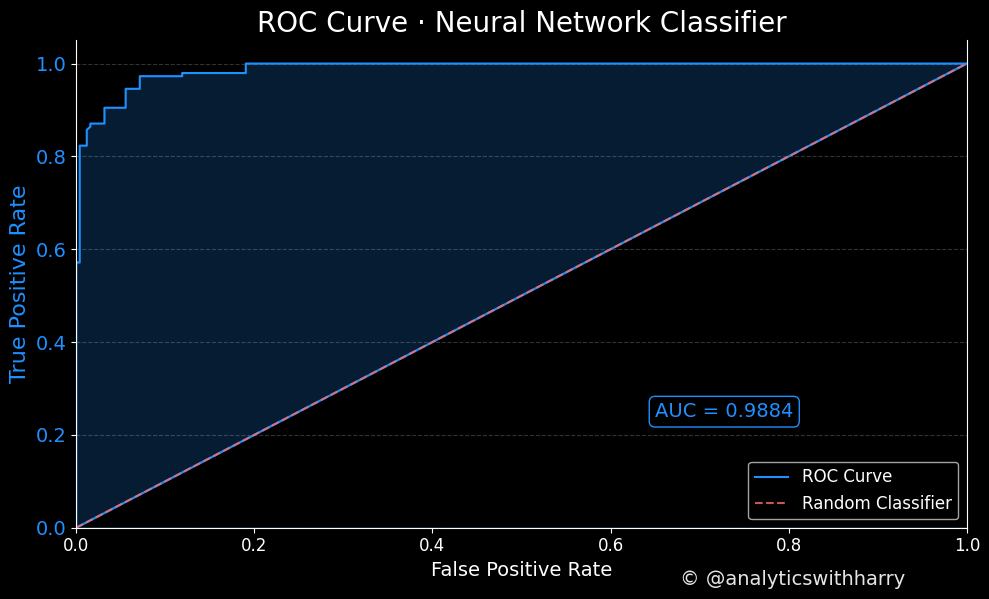

In [49]:
roc_dashboard = plot_roc_curve_dashboard(y_test, base_probabilities)

### Step 14: Prediction Confidence Analysis

This shows how confident the model is in its predictions:
- **Left plot:** Distribution of prediction probabilities for each class. Well-separated distributions indicate the model is confident.
- **Right plot:** Shows which samples were correctly (blue) vs incorrectly (red) classified based on their features.

In [50]:
# probability distribution and accuracy 
# this function charts probability histograms and accuracy
def plot_probability_and_accuracy_panels(X_test, y_test, y_pred, y_pred_proba, figsize=(16, 6)):
    with plt.style.context("dark_background"):
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        if y_pred_proba is not None:
            axes[0].hist(
                y_pred_proba[y_test == 0], bins=20, alpha=0.7,
                label="Not Purchased", color=SECONDARY_COLOR, edgecolor="white"
            )
            axes[0].hist(
                y_pred_proba[y_test == 1], bins=20, alpha=0.7,
                label="Purchased", color=PRIMARY_COLOR, edgecolor="white"
            )
            axes[0].axvline(
                x=0.5, color=ACCENT_COLOR, linestyle="--", lw=2, label="Decision Threshold"
            )
            axes[0].set_xlabel("Prediction Probability", fontsize=14, color="white")
            axes[0].set_ylabel("Frequency", fontsize=16, color=PRIMARY_COLOR)
            axes[0].set_title("Prediction Confidence Distribution", fontsize=16, color="white")
            axes[0].tick_params(axis="y", labelcolor=PRIMARY_COLOR, labelsize=14)
            axes[0].tick_params(axis="x", labelcolor="white", labelsize=12)
            axes[0].spines["top"].set_visible(False)
            axes[0].legend(fontsize=10)

        correct_mask = (y_pred == y_test)
        axes[1].scatter(
            X_test[correct_mask, 0], X_test[correct_mask, 1],
            c=PRIMARY_COLOR, marker="o", s=80, alpha=0.8, label="Correct", edgecolors="white"
        )
        axes[1].scatter(
            X_test[~correct_mask, 0], X_test[~correct_mask, 1],
            c=ACCENT_COLOR, marker="x", s=100, alpha=0.9, label="Incorrect", linewidths=2
        )
        axes[1].set_xlabel("Age (Standardized)", fontsize=14, color="white")
        axes[1].set_ylabel("Annual Salary (Standardized)", fontsize=16, color=SECONDARY_COLOR)
        axes[1].set_title("Prediction Accuracy by Sample", fontsize=16, color="white")
        axes[1].tick_params(axis="y", labelcolor=SECONDARY_COLOR, labelsize=14)
        axes[1].tick_params(axis="x", labelcolor="white", labelsize=12)
        axes[1].spines["top"].set_visible(False)
        axes[1].legend(fontsize=10)

        fig.text(0.98, 0.001, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
        fig.tight_layout()
        plt.show()

    return fig


In [51]:
# this function wraps the probability accuracy visuals
def generate_probability_accuracy_dashboard(X_test, y_test, y_pred, y_pred_proba):
    return plot_probability_and_accuracy_panels(X_test, y_test, y_pred, y_pred_proba)

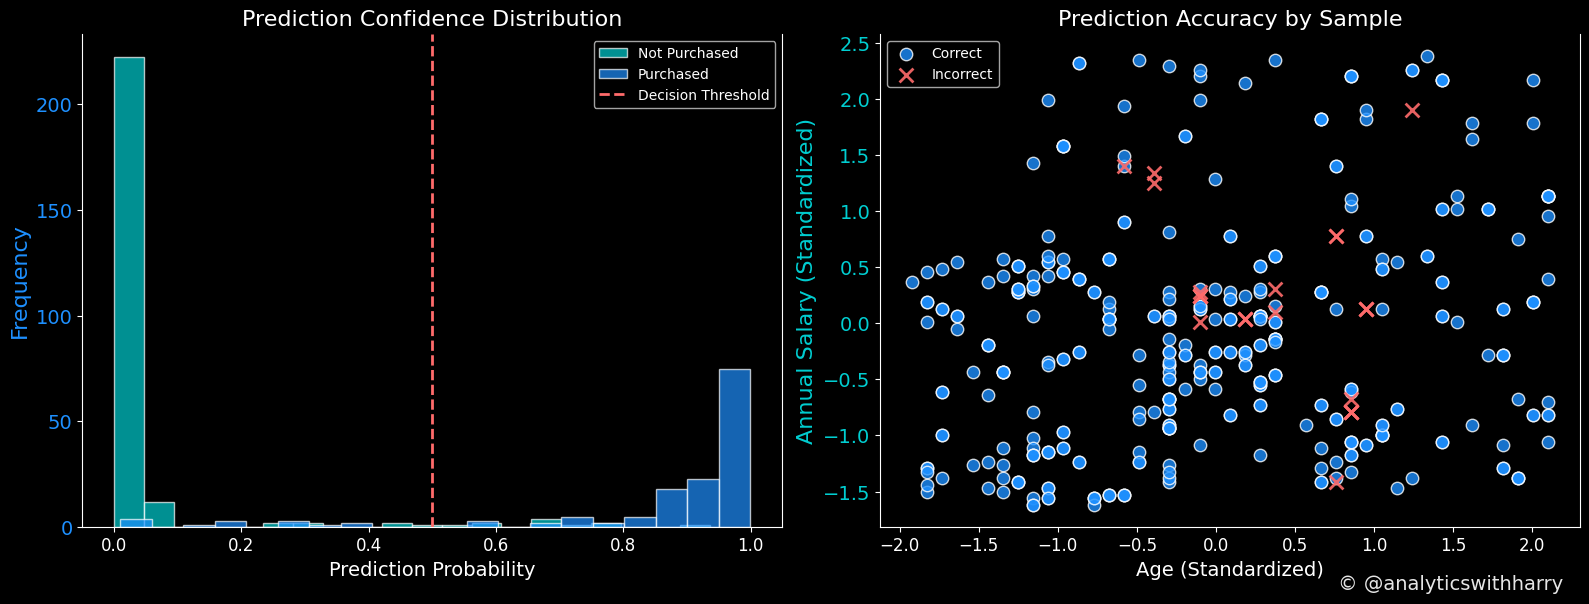

In [52]:
probability_accuracy_dashboard = generate_probability_accuracy_dashboard(X_test, y_test, base_predictions, base_probabilities)

### Step 15: Base Model Summary

Here we summarize all the performance metrics of our base model:
- **Accuracy:** Overall percentage of correct predictions
- **Precision:** Of all predicted purchases, what percentage were actual purchases
- **Recall:** Of all actual purchases, what percentage did we correctly identify
- **F1-Score:** Harmonic mean of precision and recall (balanced metric)

In [53]:
# this function summarizes the baseline model performance
def base_model_summary(y_true, y_pred, y_pred_proba, dataset_sizes, architecture):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print("=" * 60)
    print("           BASE MODEL CLASSIFICATION RESULTS")
    print("=" * 60)
    print("\nModel Architecture:")
    for idx, units in enumerate(architecture, start=1):
        print("   - Hidden Layer {}: {} neurons (ReLU)".format(idx, units))
    print("   - Output Layer:   1 neuron (Sigmoid)")
    print("\nPerformance Metrics:")
    print("   - Accuracy:  {:.2f}%".format(accuracy * 100))
    print("   - Precision: {:.2f}%".format(precision * 100))
    print("   - Recall:    {:.2f}%".format(recall * 100))
    print("   - F1-Score:  {:.2f}%".format(f1 * 100))
    if y_pred_proba is not None:
        auc_score = roc_auc_score(y_true, y_pred_proba)
        print("   - AUC-ROC:   {:.4f}".format(auc_score))
    print("\nDataset Info:")
    print("   - Total samples:    {}".format(dataset_sizes["total"]))
    print("   - Training samples: {} ({:.0f}%)".format(dataset_sizes["train"], dataset_sizes["train"] / dataset_sizes["total"] * 100))
    print("   - Test samples:     {} ({:.0f}%)".format(dataset_sizes["test"], dataset_sizes["test"] / dataset_sizes["total"] * 100))
    print("\nBase model trained and evaluated successfully!")
    print("=" * 60)
    print("\n" + COPYRIGHT_TEXT)

In [54]:
base_summary = base_model_summary(y_test, base_predictions, base_probabilities, {"total": len(y_raw), "train": len(y_train), "test": len(y_test)}, (128, 64, 32, 16))

           BASE MODEL CLASSIFICATION RESULTS

Model Architecture:
   - Hidden Layer 1: 128 neurons (ReLU)
   - Hidden Layer 2: 64 neurons (ReLU)
   - Hidden Layer 3: 32 neurons (ReLU)
   - Hidden Layer 4: 16 neurons (ReLU)
   - Output Layer:   1 neuron (Sigmoid)

Performance Metrics:
   - Accuracy:  93.73%
   - Precision: 92.36%
   - Recall:    90.48%
   - F1-Score:  91.41%
   - AUC-ROC:   0.9884

Dataset Info:
   - Total samples:    2000
   - Training samples: 1601 (80%)
   - Test samples:     399 (20%)

Base model trained and evaluated successfully!

© @analyticswithharry


---

## Part 2: Automatic Model Selection

### Step 16: Comprehensive Hyperparameter Search

This step automatically finds the best neural network configuration by testing many combinations of:
- **Activation Functions:** ReLU, Tanh, Logistic (Sigmoid)
- **Hidden Layer Architectures:** Various depths and neuron counts
- **Learning Rates:** Different speeds of learning
- **Batch Sizes:** How many samples to process at once
- **Regularization (Alpha):** Prevents overfitting

The system evaluates each combination and automatically selects the best performing model.

In [55]:
# this function runs the hyperparameter tuning loop
def run_hyperparameter_search(X_train, y_train, X_test, y_test, verbose=True):
    param_grid = {
        "hidden_layer_sizes": [
            (16,), (32,), (64,), (128,),
            (16, 8), (32, 16), (64, 32), (128, 64),
            (32, 16, 8), (64, 32, 16), (128, 64, 32),
            (64, 32, 16, 8), (128, 64, 32, 16),
        ],
        "activation": ["relu", "tanh", "logistic"],
        "learning_rate_init": [0.0001, 0.0005, 0.001, 0.005, 0.01],
    }
    tuning_results = []
    total_combinations = (
        len(param_grid["hidden_layer_sizes"]) *
        len(param_grid["activation"]) *
        len(param_grid["learning_rate_init"])
    )
    if verbose:
        print("=" * 80)
        print("       AUTOMATIC MODEL SELECTION - Comprehensive Hyperparameter Search")
        print("=" * 80)
        print("\nSearch Space:")
        print("  Architectures:     {} configurations".format(len(param_grid["hidden_layer_sizes"])))
        print("  Activations:       {}".format(param_grid["activation"]))
        print("  Learning Rates:    {}".format(param_grid["learning_rate_init"]))
        print("  Batch Size:        Fixed at 32 (fast subset)")
        print("  Alpha (L2 reg):    0.0001 (fixed)")
        print("\nTesting {} configurations (subset for efficiency)...".format(total_combinations))
        print("-" * 80)
    best_accuracy = 0
    best_f1 = 0
    best_config = None
    best_model_params = None
    config_count = 0
    for arch in param_grid["hidden_layer_sizes"]:
        for activation in param_grid["activation"]:
            for lr in param_grid["learning_rate_init"]:
                config_count += 1
                batch = 32
                alpha = 0.0001
                test_model = MLPClassifier(
                    hidden_layer_sizes=arch,
                    activation=activation,
                    solver="adam",
                    learning_rate_init=lr,
                    max_iter=20,
                    batch_size=batch,
                    alpha=alpha,
                    random_state=42,
                    verbose=False,
                )
                test_model.train(X_train, y_train)
                train_pred = test_model.infer(X_train)
                test_pred = test_model.infer(X_test)
                train_acc = accuracy_score(y_train, train_pred)
                test_acc = accuracy_score(y_test, test_pred)
                test_f1 = f1_score(y_test, test_pred)
                result = {
                    "architecture": arch,
                    "activation": activation,
                    "learning_rate": lr,
                    "batch_size": batch,
                    "alpha": alpha,
                    "train_accuracy": train_acc,
                    "test_accuracy": test_acc,
                    "test_f1": test_f1,
                    "neurons": sum(arch),
                    "layers": len(arch),
                }
                tuning_results.append(result)
                if test_acc > best_accuracy or (test_acc == best_accuracy and test_f1 > best_f1):
                    best_accuracy = test_acc
                    best_f1 = test_f1
                    best_config = result
                    best_model_params = {
                        "hidden_layer_sizes": arch,
                        "activation": activation,
                        "learning_rate_init": lr,
                        "batch_size": batch,
                        "alpha": alpha,
                    }
                if verbose and config_count % 10 == 0:
                    print(
                        "[{}/{}] Best so far: {:.2f}% | Current: {} {} LR={}".format(
                            config_count,
                            total_combinations,
                            best_accuracy * 100,
                            arch,
                            activation,
                            lr,
                        )
                    )
    if verbose:
        print("-" * 80)
        print("\nSearch Complete! Tested {} configurations.".format(config_count))
        print("\n" + "=" * 80)
        print("                    BEST MODEL CONFIGURATION FOUND")
        print("=" * 80)
        print("\n  Architecture:      {}".format(best_config["architecture"]))
        print("  Total Neurons:     {}".format(best_config["neurons"]))
        print("  Hidden Layers:     {}".format(best_config["layers"]))
        print("  Activation:        {}".format(best_config["activation"]))
        print("  Learning Rate:     {}".format(best_config["learning_rate"]))
        print("  Batch Size:        {}".format(best_config["batch_size"]))
        print("  Alpha (L2 reg):    {}".format(best_config["alpha"]))
        print("\n  Performance:")
        print("  - Train Accuracy:  {:.2f}%".format(best_config["train_accuracy"] * 100))
        print("  - Test Accuracy:   {:.2f}%".format(best_config["test_accuracy"] * 100))
        print("  - Test F1 Score:   {:.4f}".format(best_config["test_f1"]))
        print("=" * 80)
    return {
        "results": tuning_results,
        "best_config": best_config,
        "best_model_params": best_model_params,
    }

In [56]:
hyperparameter_summary = run_hyperparameter_search(X_train, y_train, X_test, y_test)

       AUTOMATIC MODEL SELECTION - Comprehensive Hyperparameter Search

Search Space:
  Architectures:     13 configurations
  Activations:       ['relu', 'tanh', 'logistic']
  Learning Rates:    [0.0001, 0.0005, 0.001, 0.005, 0.01]
  Batch Size:        Fixed at 32 (fast subset)
  Alpha (L2 reg):    0.0001 (fixed)

Testing 195 configurations (subset for efficiency)...
--------------------------------------------------------------------------------
[10/195] Best so far: 91.48% | Current: (16,) tanh LR=0.01
[20/195] Best so far: 91.73% | Current: (32,) relu LR=0.01
[30/195] Best so far: 91.98% | Current: (32,) logistic LR=0.01
[40/195] Best so far: 91.98% | Current: (64,) tanh LR=0.01
[50/195] Best so far: 91.98% | Current: (128,) relu LR=0.01
[60/195] Best so far: 91.98% | Current: (128,) logistic LR=0.01
[70/195] Best so far: 92.48% | Current: (16, 8) tanh LR=0.01
[80/195] Best so far: 92.98% | Current: (32, 16) relu LR=0.01
[90/195] Best so far: 92.98% | Current: (32, 16) logistic LR=

### Step 17: Visualize Search Results

These visualizations show the impact of different hyperparameters:
- **Top Left:** Performance by network architecture (which layer configuration works best)
- **Top Right:** Performance by activation function (ReLU vs Tanh vs Logistic)
- **Bottom:** Performance by learning rate

The best configuration is automatically highlighted.

In [57]:
# this function visualizes tuning results
def plot_hyperparameter_performance_dashboard(summary, figsize=(16, 6)):
    if summary is None:
        raise ValueError("Hyperparameter summary is required to build the dashboard.")
    results = summary.get("results") if isinstance(summary, dict) else summary
    if not results:
        raise ValueError("No tuning results available; run run_hyperparameter_search first.")
    results_df = pd.DataFrame(results).copy()
    results_df["arch_str"] = results_df["architecture"].apply(
        lambda arch: " x ".join(str(layer) for layer in arch)
    )
    with plt.style.context("dark_background"):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        arch_perf = (
            results_df.groupby("arch_str")["test_accuracy"].max().sort_values(ascending=False)
        )
        axes[0].barh(
            range(len(arch_perf)),
            arch_perf.values * 100,
            color=PRIMARY_COLOR,
            edgecolor="white",
        )
        axes[0].set_yticks(range(len(arch_perf)))
        axes[0].set_yticklabels(arch_perf.index)
        axes[0].set_xlabel("Best Test Accuracy (%)", fontsize=14, color="white")
        axes[0].set_ylabel("Hidden Layer Architecture", fontsize=14, color="white")
        axes[0].set_title("Performance by Architecture", fontsize=16, color="white")
        axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
        axes[0].spines["top"].set_visible(False)
        axes[0].spines["right"].set_visible(False)
        for idx, val in enumerate(arch_perf.values):
            axes[0].text(
                val * 100 + 0.5,
                idx,
                "{:.1f}%".format(val * 100),
                va="center",
                color="white",
                fontsize=11,
            )
        lr_perf = results_df.groupby("learning_rate")["test_accuracy"].mean()
        axes[1].bar(
            range(len(lr_perf)),
            lr_perf.values * 100,
            color=SECONDARY_COLOR,
            edgecolor="white",
            width=0.6,
        )
        axes[1].set_xticks(range(len(lr_perf)))
        axes[1].set_xticklabels([str(lr) for lr in lr_perf.index])
        axes[1].set_xlabel("Learning Rate", fontsize=14, color="white")
        axes[1].set_ylabel(
            "Average Test Accuracy (%)",
            color=SECONDARY_COLOR,
            fontsize=16,
        )
        axes[1].set_title("Performance by Learning Rate", fontsize=16, color="white")
        axes[1].tick_params(axis="y", labelcolor=SECONDARY_COLOR, labelsize=14)
        axes[1].tick_params(axis="x", labelcolor="white", labelsize=12)
        axes[1].spines["top"].set_visible(False)
        axes[1].spines["right"].set_visible(False)
        for i, val in enumerate(lr_perf.values):
            axes[1].text(
                i,
                val * 100 + 0.5,
                "{:.1f}%".format(val * 100),
                ha="center",
                color="white",
                fontsize=11,
            )
        plt.figtext(
            0.98,
            0.0001,
            COPYRIGHT_TEXT,
            ha="right",
            va="bottom",
            fontsize=14,
            color="white",
            alpha=0.9,
        )
        fig.tight_layout()
        plt.show()
    return {
        "figure": fig,
        "architecture_performance": arch_perf.to_dict(),
        "learning_rate_performance": lr_perf.to_dict(),
    }

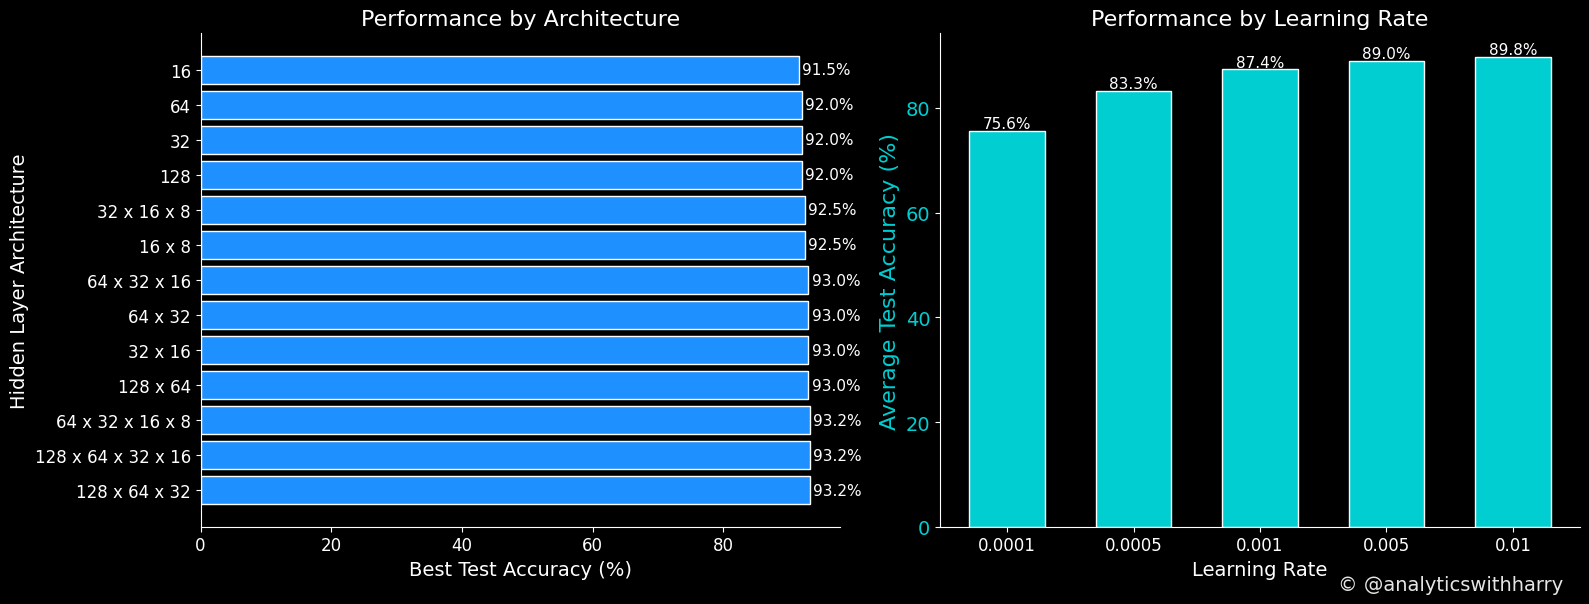

In [58]:
hyperparameter_dashboard = plot_hyperparameter_performance_dashboard(hyperparameter_summary)

### Step 18: Train the Tuned Model

Now we train a new model using the best hyperparameters found during grid search. We also enable early stopping to prevent overfitting - the training automatically stops if the model stops improving.

In [59]:
# this function retrains the model with the best config
def train_tuned_model(best_config, X_train, y_train, learning_rate=None, max_iter=10000):
    lr = learning_rate or best_config["learning_rate"]
    architecture = best_config["architecture"]
    print("Training Tuned Model with Best Configuration")
    print("=" * 60)
    optimized_model = MLPClassifier(
        hidden_layer_sizes=architecture,
        activation="relu",
        solver="adam",
        learning_rate_init=lr,
        max_iter=max_iter,
        batch_size=32,
        random_state=42,
        verbose=True,
        early_stopping=True,
        validation_fraction=0.1,
        tol=1e-4,
    )
    optimized_model.train(X_train, y_train)
    return optimized_model

In [60]:
tuned_model = train_tuned_model(hyperparameter_summary["best_config"], X_train, y_train)

Training Tuned Model with Best Configuration
Iteration 1, loss = 0.23748512
Iteration 2, loss = 0.22858990
Iteration 3, loss = 0.21988294
Iteration 4, loss = 0.21724923
Iteration 5, loss = 0.21656818
Iteration 6, loss = 0.21924386
Iteration 7, loss = 0.21405912
Iteration 8, loss = 0.21167457
Iteration 9, loss = 0.21109223
Iteration 10, loss = 0.21006797
Iteration 11, loss = 0.20970753
Iteration 12, loss = 0.20933910
Iteration 13, loss = 0.21172884
Iteration 14, loss = 0.20626469
Iteration 15, loss = 0.21019002
Iteration 16, loss = 0.20702106
Iteration 17, loss = 0.20877029
Iteration 18, loss = 0.20362803
Iteration 19, loss = 0.20540625
Iteration 20, loss = 0.20306772
Iteration 21, loss = 0.20212796
Iteration 22, loss = 0.19937335
Iteration 23, loss = 0.20167056
Converged!


In [61]:
tuned_train_accuracy, tuned_train_predictions = evaluate_accuracy(tuned_model, X_train, y_train, label="Tuned · Train")
tuned_test_accuracy, tuned_test_predictions = evaluate_accuracy(tuned_model, X_test, y_test, label="Tuned · Test")
tuned_test_probabilities = tuned_model.infer_proba(X_test)[:, 1]

Tuned · Train Accuracy: 92.63%
Tuned · Test Accuracy: 92.48%


### Step 19: Compare Base vs Tuned Model

We compare the performance of our initial base model against the tuned model:
- **Left chart:** Bar chart comparing training and test accuracy
- **Right chart:** ROC curves showing the trade-off between true positive and false positive rates

This helps us quantify how much improvement the hyperparameter tuning achieved.

In [62]:
# this function compares base and tuned model scores
def plot_model_comparison(train_scores, test_scores, labels, y_pred_proba=None, opt_pred_proba=None, y_true=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    x = np.arange(len(labels))
    width = 0.35
    bars1 = axes[0].bar(x - width / 2, train_scores, width, label="Training", color=PRIMARY_COLOR, edgecolor="white")
    bars2 = axes[0].bar(x + width / 2, test_scores, width, label="Test", color=SECONDARY_COLOR, edgecolor="white")
    axes[0].set_ylabel("Accuracy (%)", fontsize=16, color="white")
    axes[0].set_title("Model Comparison: Base vs Tuned", fontsize=16, color="white")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels, fontsize=12)
    axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0].legend(fontsize=11)
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].set_ylim([0, 105])
    for bar in list(bars1) + list(bars2):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, "{:.1f}%".format(bar.get_height()), ha="center", color="white", fontsize=11)
    if y_true is not None and y_pred_proba is not None and opt_pred_proba is not None:
        fpr_orig, tpr_orig, _ = compute_roc_curve_points(y_true, y_pred_proba)
        auc_orig = roc_auc_score(y_true, y_pred_proba)
        fpr_opt, tpr_opt, _ = compute_roc_curve_points(y_true, opt_pred_proba)
        auc_opt = roc_auc_score(y_true, opt_pred_proba)
        axes[1].plot(fpr_orig, tpr_orig, color=ACCENT_COLOR, lw=1.5, label="Base (AUC = {:.4f})".format(auc_orig), alpha=0.7)
        axes[1].plot(fpr_opt, tpr_opt, color=PRIMARY_COLOR, lw=2, label="Tuned (AUC = {:.4f})".format(auc_opt))
        axes[1].plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", alpha=0.5)
        axes[1].set_xlabel("False Positive Rate", fontsize=14, color="white")
        axes[1].set_ylabel("True Positive Rate", fontsize=14, color="white")
        axes[1].set_title("ROC Curve Comparison", fontsize=16, color="white")
        axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
        axes[1].legend(fontsize=11, loc="lower right")
        axes[1].spines["top"].set_visible(False)
        axes[1].spines["right"].set_visible(False)
    plt.figtext(0.98, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    return fig

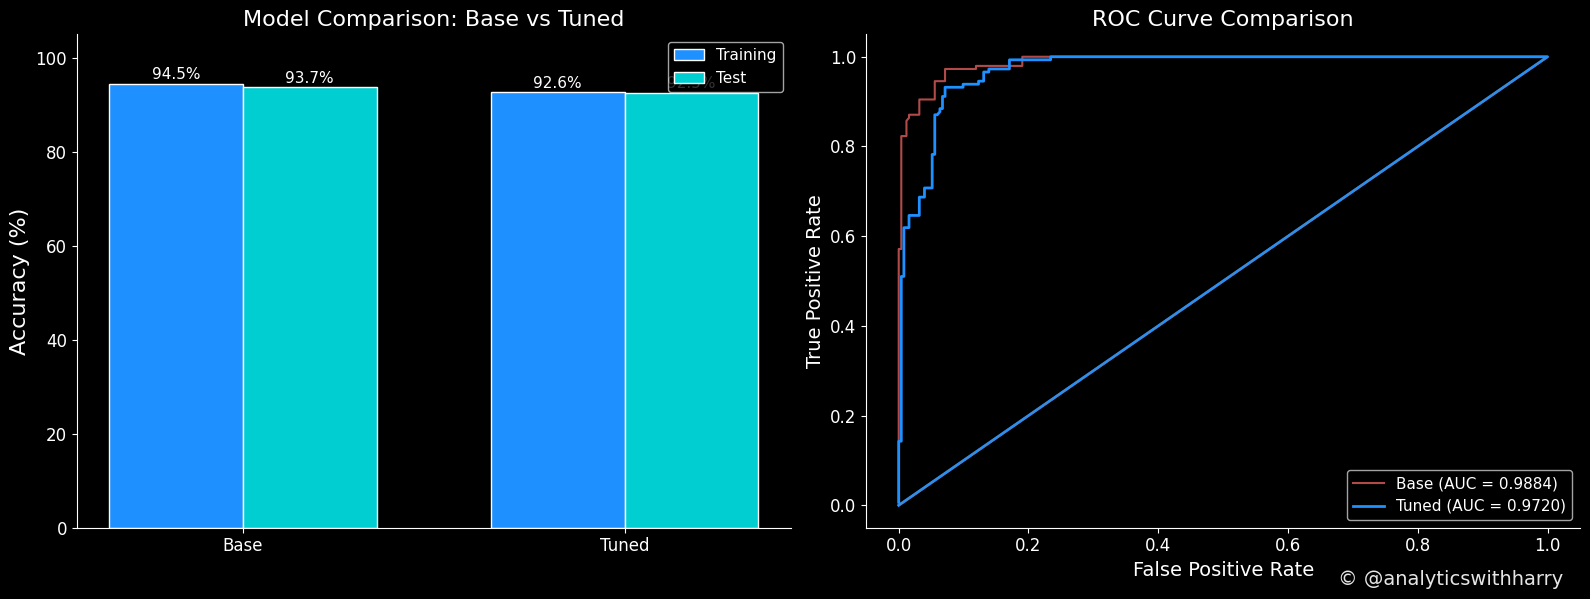

In [63]:
model_comparison_plot = plot_model_comparison(
    [base_train_accuracy * 100, tuned_train_accuracy * 100],
    [base_test_accuracy * 100, tuned_test_accuracy * 100],
    labels=["Base", "Tuned"],
    y_pred_proba=base_test_probabilities,
    opt_pred_proba=tuned_test_probabilities,
    y_true=y_test,
 )

## Step 20: Tuned Model Summary

This cell presents a comprehensive summary comparing the base model against the tuned model. We display accuracy, precision, recall, F1-score, and other metrics side by side to quantify the improvement achieved through hyperparameter tuning.

In [64]:
# this function builds a comparison table with metrics
def compare_models_table(y_true, base_preds, tuned_preds, tuned_proba, best_config, base_metrics):
    opt_precision = precision_score(y_true, tuned_preds)
    opt_recall = recall_score(y_true, tuned_preds)
    opt_f1 = f1_score(y_true, tuned_preds)
    opt_accuracy = accuracy_score(y_true, tuned_preds)
    base_accuracy = accuracy_score(y_true, base_preds)
    print("=" * 70)
    print("               MODEL COMPARISON RESULTS")
    print("=" * 70)
    print("\nBase Model {}:".format(base_metrics["architecture"]))
    print("   - Test Accuracy:  {:.2f}%".format(base_accuracy * 100))
    print("   - Test Precision: {:.2f}%".format(base_metrics["precision"] * 100))
    print("   - Test Recall:    {:.2f}%".format(base_metrics["recall"] * 100))
    print("   - Test F1-Score:  {:.2f}%".format(base_metrics["f1"] * 100))
    print("\nTuned Model {}:".format(best_config["architecture"]))
    print("   - Test Accuracy:  {:.2f}%".format(opt_accuracy * 100))
    print("   - Test Precision: {:.2f}%".format(opt_precision * 100))
    print("   - Test Recall:    {:.2f}%".format(opt_recall * 100))
    print("   - Test F1-Score:  {:.2f}%".format(opt_f1 * 100))
    if tuned_proba is not None:
        opt_auc = roc_auc_score(y_true, tuned_proba)
        print("   - AUC-ROC:        {:.4f}".format(opt_auc))
    print("\nImprovement:")
    print("   - Accuracy:  {:+.2f}%".format((opt_accuracy - base_accuracy) * 100))
    print("   - F1-Score:  {:+.2f}%".format((opt_f1 - base_metrics["f1"]) * 100))
    print("\nBest Hyperparameters:")
    print("   - Hidden Layers:  {}".format(best_config["architecture"]))
    print("   - Learning Rate:  {}".format(best_config["learning_rate"]))
    print("   - Batch Size:     {}".format(best_config["batch_size"]))
    print("   - Alpha (L2 reg): {}".format(best_config["alpha"]))
    print("\n" + "=" * 70)
    print("Hyperparameter tuning complete!")
    print("=" * 70)
    print("\n" + COPYRIGHT_TEXT)

In [65]:
comparison_table = compare_models_table(
    y_test,
    base_test_predictions,
    tuned_test_predictions,
    tuned_test_probabilities,
    hyperparameter_summary["best_config"],
    {
        "architecture": (128, 64, 32, 16),
        "precision": precision_score(y_test, base_test_predictions),
        "recall": recall_score(y_test, base_test_predictions),
        "f1": f1_score(y_test, base_test_predictions),
    },
)

               MODEL COMPARISON RESULTS

Base Model (128, 64, 32, 16):
   - Test Accuracy:  93.73%
   - Test Precision: 92.36%
   - Test Recall:    90.48%
   - Test F1-Score:  91.41%

Tuned Model (128, 64, 32):
   - Test Accuracy:  92.48%
   - Test Precision: 88.74%
   - Test Recall:    91.16%
   - Test F1-Score:  89.93%
   - AUC-ROC:        0.9720

Improvement:
   - Accuracy:  -1.25%
   - F1-Score:  -1.48%

Best Hyperparameters:
   - Hidden Layers:  (128, 64, 32)
   - Learning Rate:  0.01
   - Batch Size:     32
   - Alpha (L2 reg): 0.0001

Hyperparameter tuning complete!

© @analyticswithharry


## Step 21: Epoch-wise Training Metrics

In this step, we train the model while tracking metrics at each epoch. An epoch represents one complete pass through the training data. By observing how training and validation metrics change over epochs, we can detect overfitting, underfitting, or optimal stopping points.

In [66]:
# this function tracks metrics across training epochs
def track_epoch_metrics(best_config, X_train, y_train, max_epochs=100, val_fraction=0.15):
    print("Training model with epoch-wise metrics tracking...")
    print("-" * 60)
    val_size = int(val_fraction * len(X_train))
    X_val = X_train[:val_size]
    y_val = y_train[:val_size]
    X_train_sub = X_train[val_size:]
    y_train_sub = y_train[val_size:]
    epochs_list, train_losses, val_losses = [], [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(1, max_epochs + 1):
        epoch_model = MLPClassifier(
            hidden_layer_sizes=best_config["architecture"],
            activation="relu",
            solver="adam",
            learning_rate_init=best_config["learning_rate"],
            max_iter=epoch * 100,
            batch_size=32,
            random_state=42,
            verbose=False,
        )
        epoch_model.train(X_train_sub, y_train_sub)
        train_pred_epoch = epoch_model.infer(X_train_sub)
        val_pred_epoch = epoch_model.infer(X_val)
        train_acc_epoch = accuracy_score(y_train_sub, train_pred_epoch)
        val_acc_epoch = accuracy_score(y_val, val_pred_epoch)
        train_proba = epoch_model.infer_proba(X_train_sub)[:, 1]
        val_proba = epoch_model.infer_proba(X_val)[:, 1]
        train_loss = log_loss(y_train_sub, train_proba)
        val_loss = log_loss(y_val, val_proba)
        epochs_list.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc_epoch)
        val_accuracies.append(val_acc_epoch)
        if epoch % 20 == 0:
            print("Epoch {:3d} | Train Acc: {:.2f}% | Val Acc: {:.2f}%".format(epoch, train_acc_epoch * 100, val_acc_epoch * 100))
    print("-" * 60)
    print("Tracking complete!")
    return {
        "epochs": epochs_list,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

In [67]:
epoch_history = track_epoch_metrics(hyperparameter_summary["best_config"], X_train, y_train)

Training model with epoch-wise metrics tracking...
------------------------------------------------------------
Epoch  20 | Train Acc: 94.56% | Val Acc: 91.67%
Epoch  40 | Train Acc: 94.56% | Val Acc: 91.67%
Epoch  60 | Train Acc: 94.56% | Val Acc: 91.67%
Epoch  80 | Train Acc: 94.56% | Val Acc: 91.67%
Epoch 100 | Train Acc: 94.56% | Val Acc: 91.67%
------------------------------------------------------------
Tracking complete!


## Step 22: Visualize Epoch-wise Training Progress

This visualization shows how loss and accuracy evolve over training epochs. Two plots are displayed side by side: the left shows loss curves (lower is better) and the right shows accuracy curves (higher is better). Ideally, both training and validation curves should converge, with validation slightly below training.

In [68]:
# this function visualizes the tracked epoch metrics
def plot_epoch_performance(epoch_summary):
    epochs_list = epoch_summary["epochs"]
    train_losses = epoch_summary["train_losses"]
    val_losses = epoch_summary["val_losses"]
    train_accuracies = epoch_summary["train_accuracies"]
    val_accuracies = epoch_summary["val_accuracies"]
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].plot(epochs_list, train_losses, color=PRIMARY_COLOR, lw=1.5, label="Training Loss")
    axes[0].plot(epochs_list, val_losses, color=SECONDARY_COLOR, lw=1.5, label="Validation Loss")
    axes[0].set_xlabel("Epoch", fontsize=14, color="white")
    axes[0].set_ylabel("Loss (Binary Cross-Entropy)", fontsize=16, color="white")
    axes[0].set_title("Training vs Validation Loss", fontsize=20, color="white")
    axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0].legend(fontsize=12, loc="upper right")
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].grid(True, axis="y", ls="--", alpha=0.2, color="white")
    axes[1].plot(epochs_list, [a * 100 for a in train_accuracies], color=PRIMARY_COLOR, lw=1.5, label="Training Accuracy")
    axes[1].plot(epochs_list, [a * 100 for a in val_accuracies], color=SECONDARY_COLOR, lw=1.5, label="Validation Accuracy")
    axes[1].set_xlabel("Epoch", fontsize=14, color="white")
    axes[1].set_ylabel("Accuracy (%)", fontsize=16, color="white")
    axes[1].set_title("Training vs Validation Accuracy", fontsize=20, color="white")
    axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1].legend(fontsize=12, loc="lower right")
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].grid(True, axis="y", ls="--", alpha=0.2, color="white")
    plt.figtext(0.98, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    summary = {
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "final_train_acc": train_accuracies[-1] * 100,
        "final_val_acc": val_accuracies[-1] * 100,
    }
    print("\nTraining Summary:")
    print("=" * 50)
    for key, value in summary.items():
        label = key.replace("_", " ").title()
        suffix = "" if "loss" in key else "%"
        print("{}: {:.2f}{}".format(label, value, suffix))
    return fig, summary

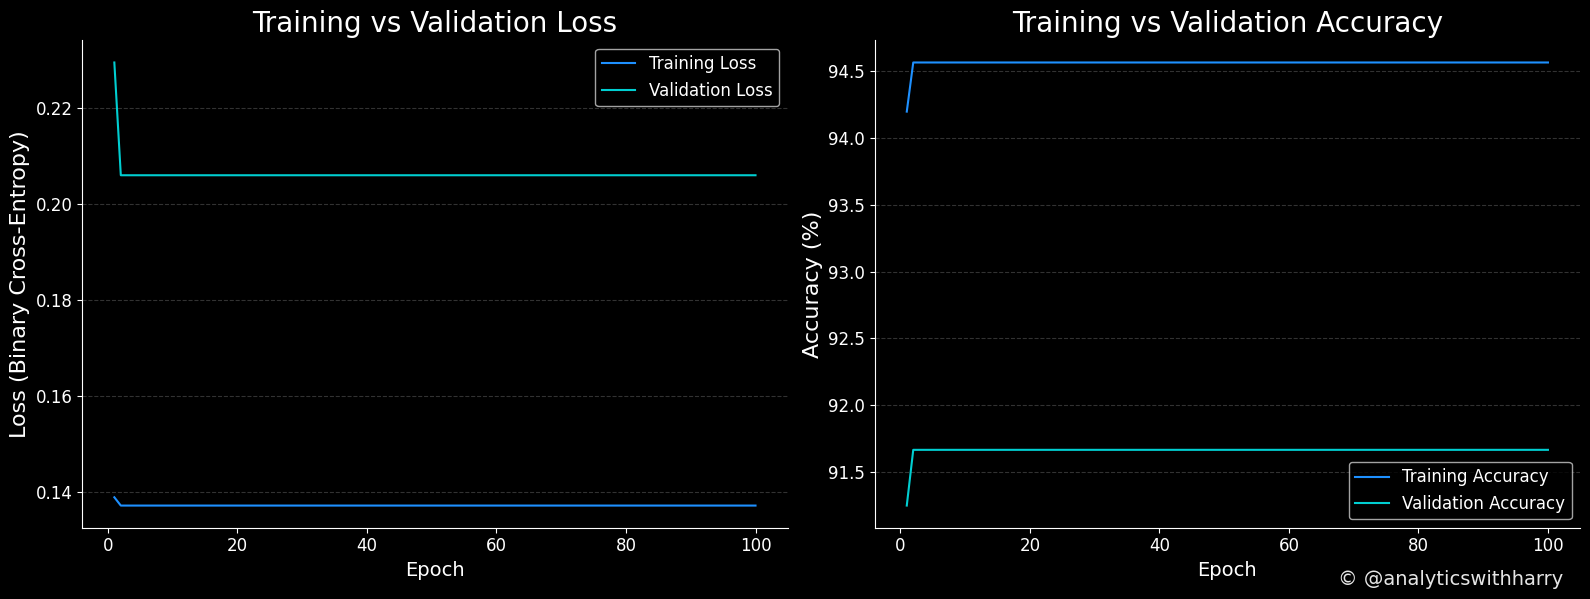


Training Summary:
Final Train Loss: 0.14
Final Val Loss: 0.21
Final Train Acc: 94.56%
Final Val Acc: 91.67%


In [69]:
epoch_fig, epoch_summary = plot_epoch_performance(epoch_history)

---

# Part 3: Advanced Model Analysis

This section provides comprehensive model evaluation using advanced metrics and visualization techniques. We will examine precision-recall trade-offs, calibration quality, optimal threshold selection, per-class performance, error patterns, learning curves, feature contributions, and correlation-based metrics.

## Step 23: Precision-Recall Curve

The precision-recall curve shows the trade-off between precision (how many predicted positives are correct) and recall (how many actual positives we capture). This is especially useful for imbalanced datasets where accuracy alone can be misleading.

In [70]:
# this function computes precision recall arrays
def compute_precision_recall_curve(y_true, y_score):
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]
    y_score_sorted = np.array(y_score)[sorted_indices]
    thresholds = np.unique(y_score_sorted)
    precisions, recalls = [], []
    for thresh in thresholds:
        y_pred_thresh = (y_score >= thresh).astype(int)
        tp = np.sum((y_pred_thresh == 1) & (y_true == 1))
        fp = np.sum((y_pred_thresh == 1) & (y_true == 0))
        fn = np.sum((y_pred_thresh == 0) & (y_true == 1))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    return np.array(precisions), np.array(recalls), thresholds

# this function plots precision recall diagnostics
def plot_precision_recall_analysis(y_true, y_score):
    if y_score is None:
        raise ValueError("Prediction probabilities are required for PR analysis")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    precision_curve, recall_curve, _ = compute_precision_recall_curve(y_true, y_score)
    avg_precision = np.sum(np.diff(np.concatenate([[0], recall_curve])) * precision_curve)
    axes[0].plot(recall_curve, precision_curve, color=PRIMARY_COLOR, lw=1.5, label="Precision-Recall Curve")
    axes[0].fill_between(recall_curve, precision_curve, alpha=0.2, color=PRIMARY_COLOR)
    axes[0].axhline(y=np.mean(y_true), color=ACCENT_COLOR, linestyle="--", lw=1.5, label="No Skill ({:.2f})".format(np.mean(y_true)))
    axes[0].text(0.5, 0.85, "AP = {:.4f}".format(avg_precision), transform=axes[0].transAxes, color=PRIMARY_COLOR, fontsize=14, bbox=dict(facecolor="black", edgecolor=PRIMARY_COLOR, boxstyle="round,pad=0.3"))
    axes[0].set_xlabel("Recall", fontsize=14, color="white")
    axes[0].set_ylabel("Precision", color=PRIMARY_COLOR, fontsize=16)
    axes[0].set_title("Precision-Recall Curve", fontsize=20, color="white")
    axes[0].tick_params(axis="y", labelcolor=PRIMARY_COLOR, labelsize=14)
    axes[0].tick_params(axis="x", labelcolor="white", labelsize=12)
    axes[0].spines["top"].set_visible(False)
    axes[0].legend(fontsize=12, loc="lower left")
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].grid(True, ls="--", alpha=0.2, color="white")
    thresholds_range = np.linspace(0.1, 0.9, 50)
    f1_scores, precision_scores, recall_scores = [], [], []
    for thresh in thresholds_range:
        y_pred_thresh = (y_score >= thresh).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_thresh))
        precision_scores.append(precision_score(y_true, y_pred_thresh, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_thresh, zero_division=0))
    axes[1].plot(thresholds_range, f1_scores, color=PRIMARY_COLOR, lw=2, label="F1 Score")
    axes[1].plot(thresholds_range, precision_scores, color=SECONDARY_COLOR, lw=1.5, label="Precision", alpha=0.8)
    axes[1].plot(thresholds_range, recall_scores, color=TERTIARY_COLOR, lw=1.5, label="Recall", alpha=0.8)
    optimal_idx = int(np.argmax(f1_scores))
    optimal_thresh = thresholds_range[optimal_idx]
    axes[1].axvline(x=optimal_thresh, color=ACCENT_COLOR, linestyle="--", lw=1.5)
    axes[1].scatter([optimal_thresh], [f1_scores[optimal_idx]], color=ACCENT_COLOR, s=100, zorder=5)
    axes[1].text(optimal_thresh + 0.03, f1_scores[optimal_idx], "Optimal: {:.2f}".format(optimal_thresh), color=ACCENT_COLOR, fontsize=12)
    axes[1].set_xlabel("Threshold", fontsize=14, color="white")
    axes[1].set_ylabel("Score", fontsize=16, color="white")
    axes[1].set_title("Metrics vs Classification Threshold", fontsize=20, color="white")
    axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1].legend(fontsize=12, loc="lower left")
    axes[1].spines["top"].set_visible(False)
    axes[1].grid(True, ls="--", alpha=0.2, color="white")
    plt.figtext(0.98, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nOptimal Threshold: {:.2f} (F1 Score: {:.4f})".format(optimal_thresh, f1_scores[optimal_idx]))
    return {
        "figure": fig,
        "optimal_threshold": optimal_thresh,
        "optimal_f1": f1_scores[optimal_idx],
    }

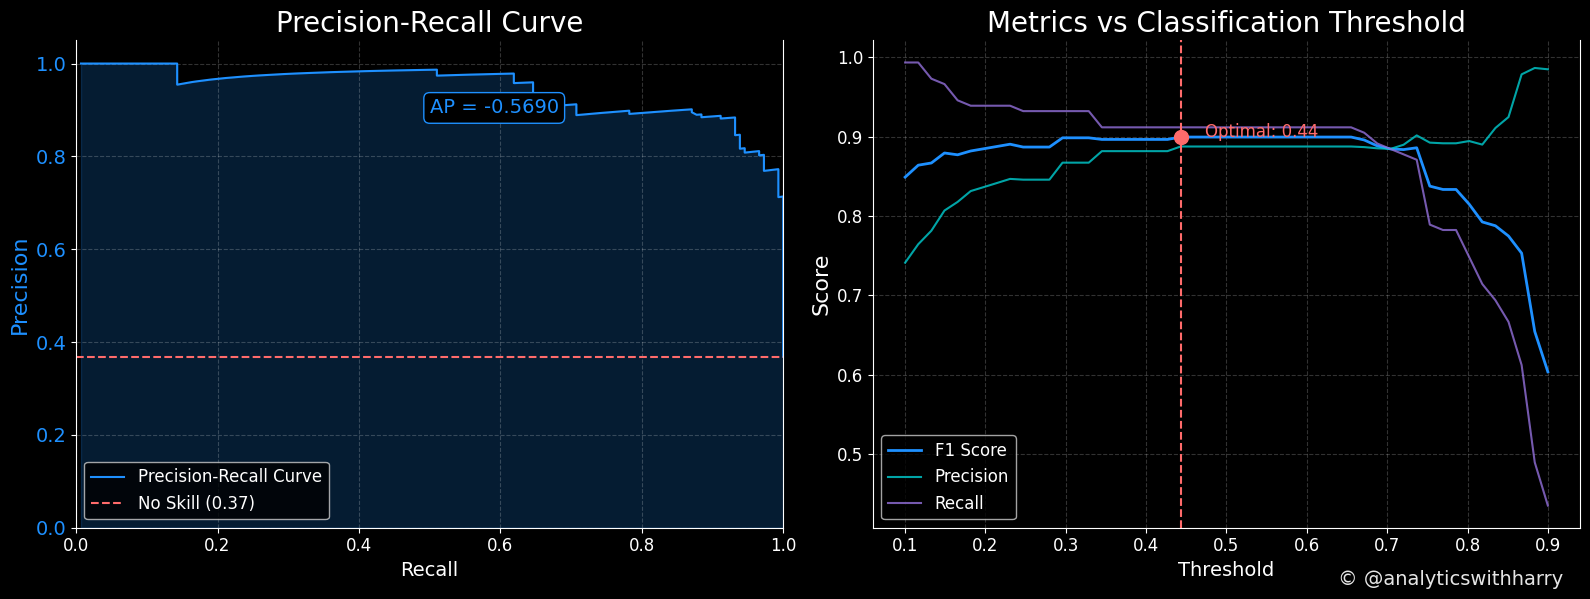


Optimal Threshold: 0.44 (F1 Score: 0.8993)


In [71]:
precision_recall_summary = plot_precision_recall_analysis(y_test, tuned_test_probabilities)

## Step 24: Calibration Curve

A calibration curve (reliability diagram) shows how well the model's predicted probabilities match actual outcomes. A perfectly calibrated model's curve would follow the diagonal line. We also show a histogram of prediction counts to understand the probability distribution.

In [72]:
# this function computes calibration bin stats
def compute_calibration_curve(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_prob, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    mean_predicted, fraction_positives, bin_counts = [], [], []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            mean_predicted.append(np.mean(y_prob[mask]))
            fraction_positives.append(np.mean(y_true[mask]))
            bin_counts.append(np.sum(mask))
        else:
            mean_predicted.append(np.nan)
            fraction_positives.append(np.nan)
            bin_counts.append(0)
    return np.array(mean_predicted), np.array(fraction_positives), np.array(bin_counts)

# this function plots calibration curves and histograms
def plot_calibration_dashboard(y_true, y_prob, n_bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    mean_pred, frac_pos, bin_counts = compute_calibration_curve(y_true, y_prob, n_bins=n_bins)
    axes[0].plot([0, 1], [0, 1], color=ACCENT_COLOR, linestyle="--", lw=2, label="Perfectly Calibrated")
    valid_mask = ~np.isnan(mean_pred)
    axes[0].plot(mean_pred[valid_mask], frac_pos[valid_mask], color=PRIMARY_COLOR, lw=2, marker="o", markersize=8, label="Model Calibration")
    ece = np.nansum(bin_counts * np.abs(mean_pred - frac_pos)) / np.sum(bin_counts)
    axes[0].text(0.6, 0.15, "ECE = {:.4f}".format(ece), transform=axes[0].transAxes, color=PRIMARY_COLOR, fontsize=14, bbox=dict(facecolor="black", edgecolor=PRIMARY_COLOR, boxstyle="round,pad=0.3"))
    axes[0].set_xlabel("Mean Predicted Probability", fontsize=14, color="white")
    axes[0].set_ylabel("Fraction of Positives", color=PRIMARY_COLOR, fontsize=16)
    axes[0].set_title("Calibration Curve (Reliability Diagram)", fontsize=20, color="white")
    axes[0].tick_params(axis="y", labelcolor=PRIMARY_COLOR, labelsize=14)
    axes[0].tick_params(axis="x", labelcolor="white", labelsize=12)
    axes[0].spines["top"].set_visible(False)
    axes[0].legend(fontsize=12, loc="upper left")
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].grid(True, ls="--", alpha=0.2, color="white")
    axes[1].hist(y_prob[y_true == 0], bins=20, alpha=0.7, label="Not Purchased", color=SECONDARY_COLOR, edgecolor="white")
    axes[1].hist(y_prob[y_true == 1], bins=20, alpha=0.7, label="Purchased", color=PRIMARY_COLOR, edgecolor="white")
    axes[1].axvline(x=0.5, color=ACCENT_COLOR, linestyle="--", lw=2, label="Decision Threshold")
    axes[1].set_xlabel("Predicted Probability", fontsize=14, color="white")
    axes[1].set_ylabel("Count", color=SECONDARY_COLOR, fontsize=16)
    axes[1].set_title("Prediction Probability Distribution", fontsize=20, color="white")
    axes[1].tick_params(axis="y", labelcolor=SECONDARY_COLOR, labelsize=14)
    axes[1].tick_params(axis="x", labelcolor="white", labelsize=12)
    axes[1].spines["top"].set_visible(False)
    axes[1].legend(fontsize=12)
    plt.figtext(0.98, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nCalibration Analysis:")
    print("=" * 50)
    print("Expected Calibration Error (ECE): {:.4f}".format(ece))
    print("(Lower ECE indicates better calibration)")
    return {
        "figure": fig,
        "ece": ece,
    }

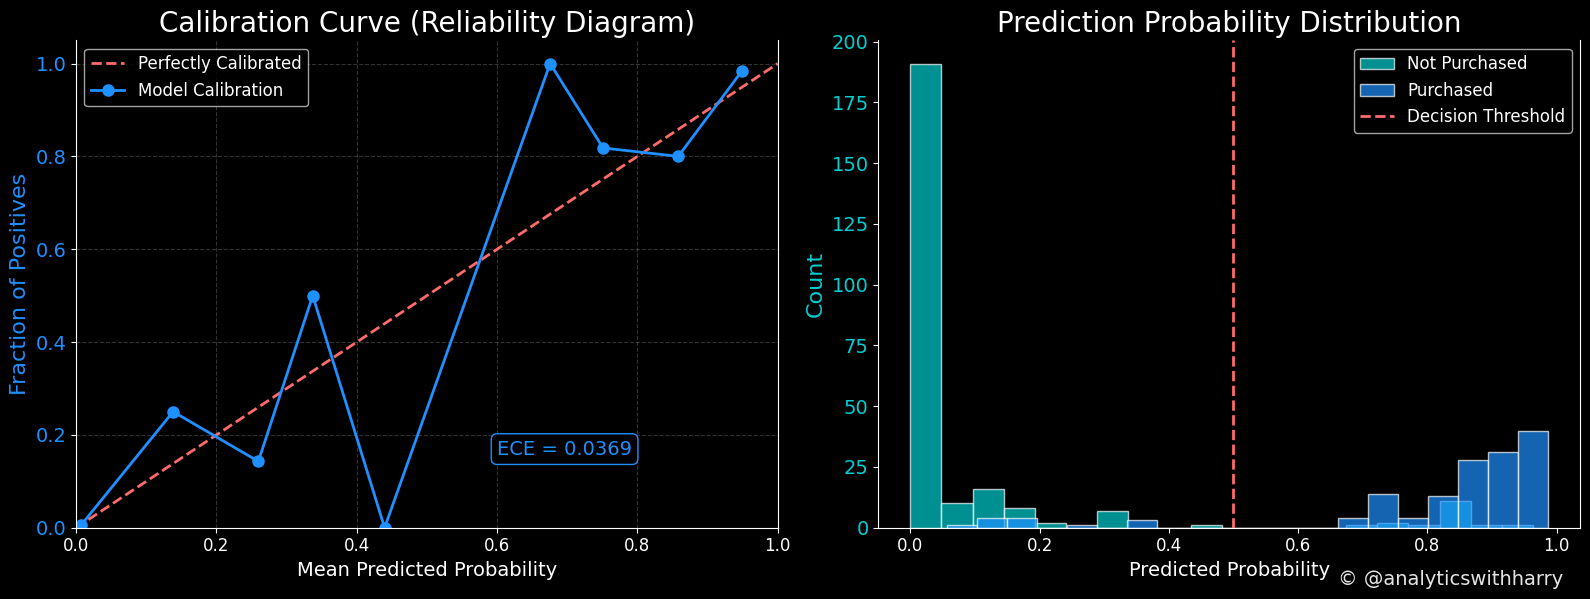


Calibration Analysis:
Expected Calibration Error (ECE): 0.0369
(Lower ECE indicates better calibration)


In [73]:
calibration_summary = plot_calibration_dashboard(y_test, tuned_test_probabilities)

## Step 25: Per-Class Performance and Error Analysis

This step examines how well the model performs on each class separately. We look at sensitivity (true positive rate), specificity (true negative rate), false positive rate, and false negative rate. Understanding these helps identify if the model is biased toward one class.

In [74]:
# this function shows where the model errs on test data
def plot_error_analysis(X_test, y_test, predictions):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    tn = np.sum((predictions == 0) & (y_test == 0))
    fp = np.sum((predictions == 1) & (y_test == 0))
    fn = np.sum((predictions == 0) & (y_test == 1))
    tp = np.sum((predictions == 1) & (y_test == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    metrics_labels = ["Sensitivity\n(TPR)", "Specificity\n(TNR)", "FPR", "FNR"]
    metrics_values = [sensitivity, specificity, fpr, fnr]
    colors = [SUCCESS_COLOR, PRIMARY_COLOR, ACCENT_COLOR, WARNING_COLOR]
    bars = axes[0].bar(range(len(metrics_labels)), metrics_values, color=colors, edgecolor="white", width=0.6)
    axes[0].set_xticks(range(len(metrics_labels)))
    axes[0].set_xticklabels(metrics_labels, fontsize=12)
    axes[0].set_ylabel("Rate", fontsize=16, color="white")
    axes[0].set_title("Per-Class Classification Rates", fontsize=20, color="white")
    axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].set_ylim([0, 1.1])
    for bar, val in zip(bars, metrics_values):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, "{:.2f}".format(val), ha="center", color="white", fontsize=12, fontweight="bold")
    fp_mask = (predictions == 1) & (y_test == 0)
    fn_mask = (predictions == 0) & (y_test == 1)
    correct_mask = predictions == y_test
    axes[1].scatter(X_test[correct_mask, 0], X_test[correct_mask, 1], c=PRIMARY_COLOR, marker="o", s=60, alpha=0.5, label="Correct", edgecolors="white")
    axes[1].scatter(X_test[fp_mask, 0], X_test[fp_mask, 1], c=ACCENT_COLOR, marker="^", s=120, alpha=0.9, label="False Positive", edgecolors="white", linewidths=1.5)
    axes[1].scatter(X_test[fn_mask, 0], X_test[fn_mask, 1], c=WARNING_COLOR, marker="v", s=120, alpha=0.9, label="False Negative", edgecolors="white", linewidths=1.5)
    axes[1].set_xlabel("Feature 1 (Standardized)", fontsize=14, color="white")
    axes[1].set_ylabel("Feature 2 (Standardized)", fontsize=14, color="white")
    axes[1].set_title("Error Analysis: Misclassification Patterns", fontsize=20, color="white")
    axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].legend(fontsize=11, loc="upper right")
    plt.figtext(0.99, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nError Analysis Summary:")
    print("=" * 50)
    print("True Positives:  {:3d} ({:.1f}%)".format(tp, tp / len(y_test) * 100))
    print("True Negatives:  {:3d} ({:.1f}%)".format(tn, tn / len(y_test) * 100))
    print("False Positives: {:3d} ({:.1f}%)".format(fp, fp / len(y_test) * 100))
    print("False Negatives: {:3d} ({:.1f}%)".format(fn, fn / len(y_test) * 100))
    print("-" * 50)
    print("Sensitivity (TPR): {:.4f}".format(sensitivity))
    print("Specificity (TNR): {:.4f}".format(specificity))
    return {
        "figure": fig,
        "rates": {
            "sensitivity": sensitivity,
            "specificity": specificity,
            "fpr": fpr,
            "fnr": fnr,
        },
    }

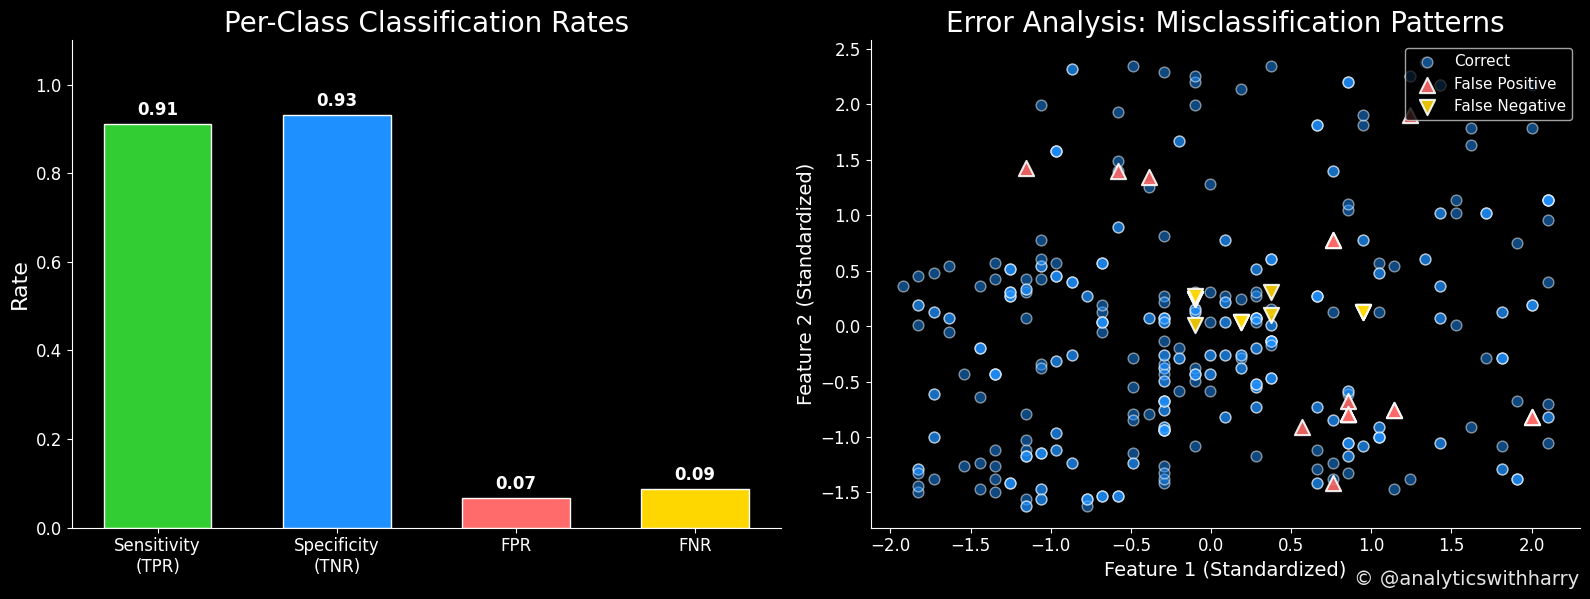


Error Analysis Summary:
True Positives:  134 (33.6%)
True Negatives:  235 (58.9%)
False Positives:  17 (4.3%)
False Negatives:  13 (3.3%)
--------------------------------------------------
Sensitivity (TPR): 0.9116
Specificity (TNR): 0.9325


In [75]:
error_dashboard = plot_error_analysis(X_test, y_test, tuned_test_predictions)

## Step 26: Learning Curve Analysis

A learning curve shows how model performance changes with different training set sizes. This helps determine if the model would benefit from more training data or if it has already saturated its learning capacity. Ideally, both training and test curves should converge at a high accuracy.

In [76]:
# this function plots learning curves over training sizes
def plot_learning_curve(best_config, X_train, y_train, X_test, y_test, num_points=10):
    print("Generating Learning Curves (Training Size vs Performance)...")
    print("-" * 60)
    train_sizes = np.linspace(0.1, 1.0, num_points)
    train_size_samples, train_scores, test_scores = [], [], []
    for train_frac in train_sizes:
        subset_size = int(len(X_train) * train_frac)
        if subset_size < 2:
            continue
        X_train_subset = X_train[:subset_size]
        y_train_subset = y_train[:subset_size]
        if len(np.unique(y_train_subset)) < 2:
            continue
        lc_model = MLPClassifier(
            hidden_layer_sizes=best_config["architecture"],
            activation="relu",
            solver="adam",
            learning_rate_init=best_config["learning_rate"],
            max_iter=500,
            batch_size=32,
            random_state=42,
            verbose=False,
        )
        lc_model.train(X_train_subset, y_train_subset)
        train_pred = lc_model.infer(X_train_subset)
        test_pred = lc_model.infer(X_test)
        train_size_samples.append(subset_size)
        train_scores.append(accuracy_score(y_train_subset, train_pred))
        test_scores.append(accuracy_score(y_test, test_pred))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(train_size_samples, [s * 100 for s in train_scores], color=PRIMARY_COLOR, lw=2, marker="o", markersize=8, label="Training Score")
    ax.plot(train_size_samples, [s * 100 for s in test_scores], color=SECONDARY_COLOR, lw=2, marker="s", markersize=8, label="Test Score")
    ax.fill_between(train_size_samples, [s * 100 for s in train_scores], [s * 100 for s in test_scores], alpha=0.1, color=PRIMARY_COLOR)
    ax.set_xlabel("Training Set Size", fontsize=14, color="white")
    ax.set_ylabel("Accuracy (%)", fontsize=16, color="white")
    ax.set_title("Learning Curve: Model Performance vs Training Size", fontsize=20, color="white")
    ax.tick_params(axis="both", labelcolor="white", labelsize=12)
    ax.legend(fontsize=12, loc="lower right")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, ls="--", alpha=0.2, color="white")
    plt.figtext(0.99, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    gap = train_scores[-1] - test_scores[-1] if train_scores and test_scores else 0
    interpretation = ("High gap suggests overfitting" if gap > 0.1 else "Low gap indicates good generalization" if gap < 0.02 else "Moderate gap - acceptable generalization")
    print("\nLearning Curve Analysis:")
    print("=" * 50)
    if train_scores and test_scores:
        print("Final Training Accuracy: {:.2f}%".format(train_scores[-1] * 100))
        print("Final Test Accuracy:     {:.2f}%".format(test_scores[-1] * 100))
    print("Generalization Gap:      {:.2f}%".format(gap * 100))
    print("Interpretation: {}".format(interpretation))
    return {
        "figure": fig,
        "final_train_accuracy": train_scores[-1] if train_scores else None,
        "final_test_accuracy": test_scores[-1] if test_scores else None,
        "gap": gap,
        "interpretation": interpretation,
    }

Generating Learning Curves (Training Size vs Performance)...
------------------------------------------------------------


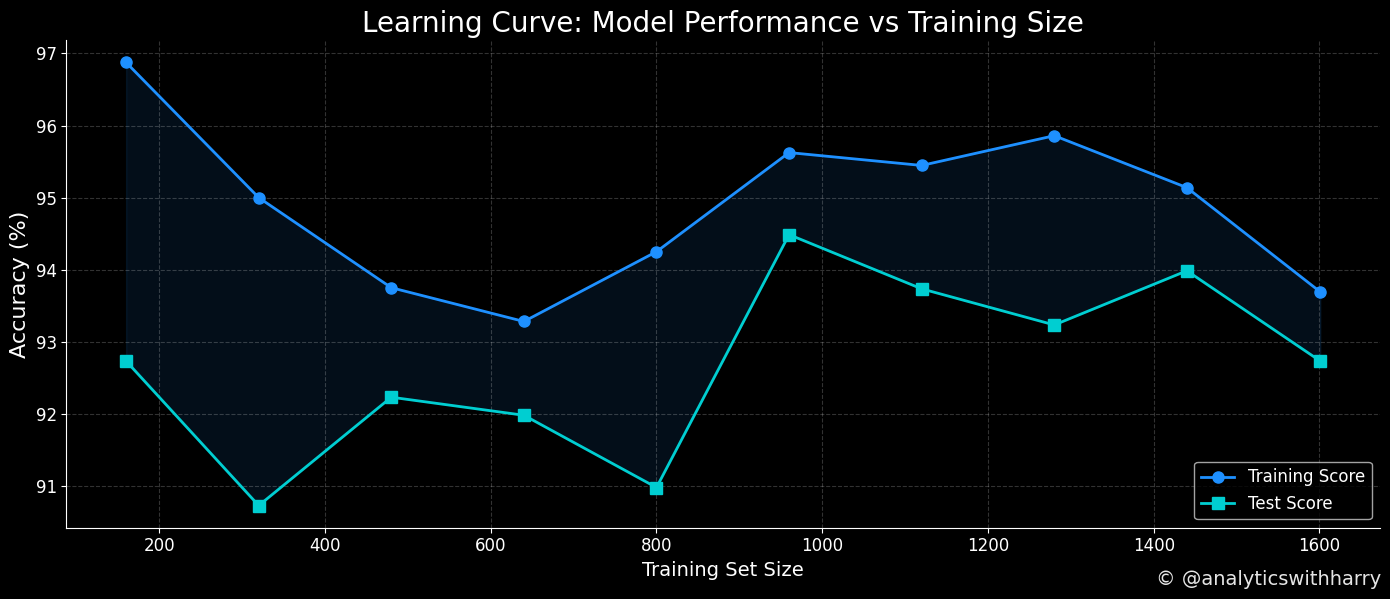


Learning Curve Analysis:
Final Training Accuracy: 93.69%
Final Test Accuracy:     92.73%
Generalization Gap:      0.96%
Interpretation: Low gap indicates good generalization


In [77]:
learning_curve_summary = plot_learning_curve(hyperparameter_summary["best_config"], X_train, y_train, X_test, y_test)

## Step 27: Feature Importance Analysis

Feature importance tells us which input variables have the most influence on the model's predictions. We use a permutation-based approach: if randomly shuffling a feature significantly reduces accuracy, that feature is important. We also visualize how each feature correlates with predictions.

In [78]:
# this function estimates permutation feature importance
def permutation_importance(model, X, y, n_repeats=10):
    baseline_accuracy = accuracy_score(y, model.infer(X))
    importances = np.zeros((X.shape[1], n_repeats))
    for col_idx in range(X.shape[1]):
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col_idx])
            permuted_accuracy = accuracy_score(y, model.infer(X_permuted))
            importances[col_idx, repeat] = baseline_accuracy - permuted_accuracy
    return importances.mean(axis=1), importances.std(axis=1)

# this function visualizes feature importance results
def plot_feature_importance(model, X_test, y_test, feature_names, y_proba=None):
    importances_mean, importances_std = permutation_importance(model, X_test, y_test)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sorted_idx = np.argsort(importances_mean)
    colors = [PRIMARY_COLOR, SECONDARY_COLOR]
    bars = axes[0].barh(range(len(feature_names)), importances_mean[sorted_idx], xerr=importances_std[sorted_idx], color=[colors[i] for i in sorted_idx], edgecolor="white", capsize=5)
    axes[0].set_yticks(range(len(feature_names)))
    axes[0].set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=14)
    axes[0].set_xlabel("Mean Accuracy Decrease", fontsize=14, color="white")
    axes[0].set_title("Feature Importance (Permutation-based)", fontsize=20, color="white")
    axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].axvline(x=0, color="white", linestyle="-", lw=0.5, alpha=0.5)
    for bar, val in zip(bars, importances_mean[sorted_idx]):
        axes[0].text(val + 0.005, bar.get_y() + bar.get_height() / 2, "{:.4f}".format(val), va="center", color="white", fontsize=12)
    if y_proba is not None:
        scatter = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_proba, cmap="coolwarm", s=60, alpha=0.8, edgecolors="white", linewidths=0.5)
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label("Prediction Probability", fontsize=12, color="white")
        cbar.ax.tick_params(labelsize=10, colors="white")
        axes[1].set_xlabel("Feature 1 (Standardized)", fontsize=14, color="white")
        axes[1].set_ylabel("Feature 2 (Standardized)", fontsize=14, color="white")
        axes[1].set_title("Feature Space with Prediction Confidence", fontsize=20, color="white")
        axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
        axes[1].spines["top"].set_visible(False)
        axes[1].spines["right"].set_visible(False)
    plt.figtext(0.99, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nFeature Importance Summary:")
    print("=" * 50)
    for i, name in enumerate(feature_names):
        print("{:15s}: {:.4f} (+/-{:.4f})".format(name, importances_mean[i], importances_std[i]))
    most_important = feature_names[int(np.argmax(importances_mean))]
    print("\nMost Important Feature: {}".format(most_important))
    return {
        "figure": fig,
        "importances": importances_mean,
        "std": importances_std,
        "most_important": most_important,
    }

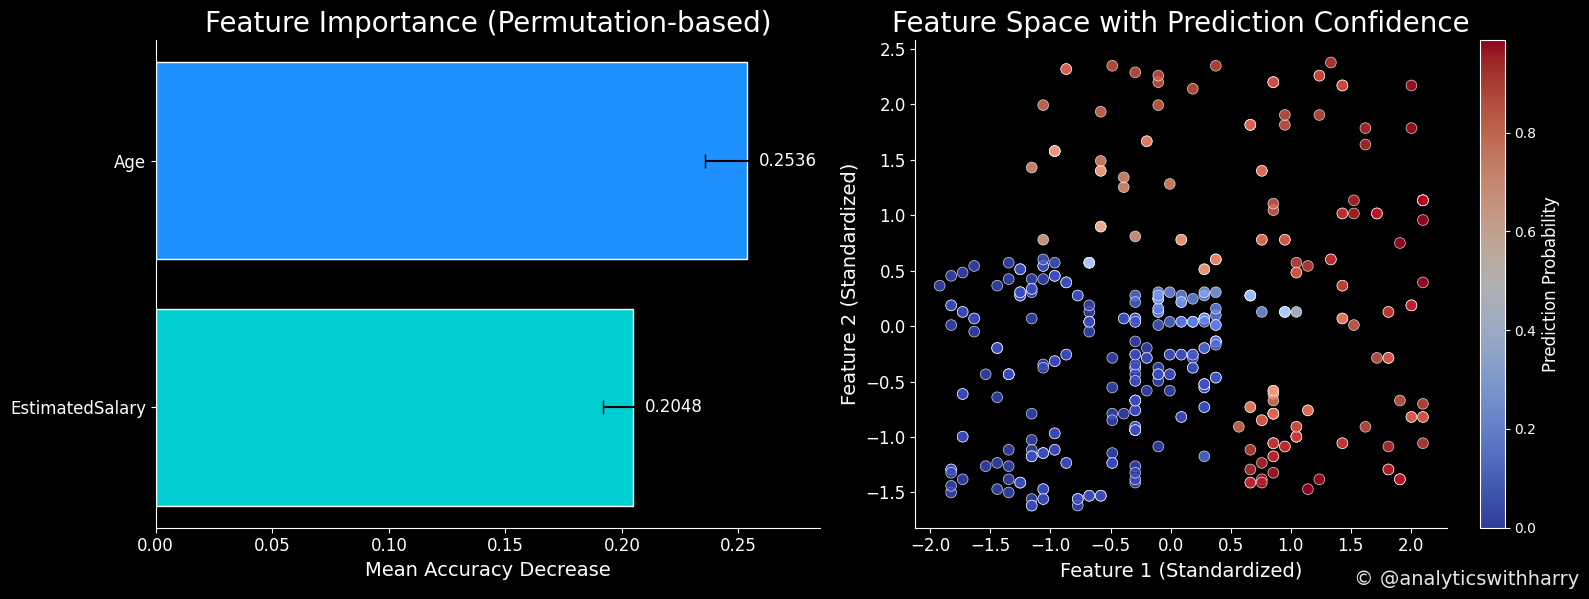


Feature Importance Summary:
Age            : 0.2536 (+/-0.0179)
EstimatedSalary: 0.2048 (+/-0.0130)

Most Important Feature: Age


In [79]:
feature_importance_summary = plot_feature_importance(tuned_model, X_test, y_test, feature_names, y_proba=tuned_test_probabilities)

## Step 28: Advanced Metrics - MCC and Cohen's Kappa

Matthews Correlation Coefficient (MCC) and Cohen's Kappa are correlation-based metrics that provide a more balanced evaluation than accuracy, especially for imbalanced datasets. MCC ranges from -1 (inverse prediction) to +1 (perfect prediction), with 0 meaning random guessing.

In [80]:
# this function computes matthews correlation
def matthews_corrcoef_custom(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / denominator if denominator > 0 else 0

# this function computes cohens kappa
def cohens_kappa_custom(y_true, y_pred):
    p_observed = np.mean(y_true == y_pred)
    pos_true = np.mean(y_true == 1)
    pos_pred = np.mean(y_pred == 1)
    neg_true = 1 - pos_true
    neg_pred = 1 - pos_pred
    p_expected = (pos_true * pos_pred) + (neg_true * neg_pred)
    return (p_observed - p_expected) / (1 - p_expected) if (1 - p_expected) > 0 else 0

# this function plots the advanced metric comparisons
def plot_advanced_metrics(y_true, base_preds, tuned_preds):
    mcc_original = matthews_corrcoef_custom(y_true, base_preds)
    mcc_optimized = matthews_corrcoef_custom(y_true, tuned_preds)
    kappa_original = cohens_kappa_custom(y_true, base_preds)
    kappa_optimized = cohens_kappa_custom(y_true, tuned_preds)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    metrics_names = ["MCC", "Cohen's Kappa", "Accuracy", "F1 Score"]
    original_metrics = [mcc_original, kappa_original, accuracy_score(y_true, base_preds), f1_score(y_true, base_preds)]
    optimized_metrics = [mcc_optimized, kappa_optimized, accuracy_score(y_true, tuned_preds), f1_score(y_true, tuned_preds)]
    x = np.arange(len(metrics_names))
    width = 0.35
    bars1 = axes[0].bar(x - width / 2, original_metrics, width, label="Original Model", color=ACCENT_COLOR, edgecolor="white")
    bars2 = axes[0].bar(x + width / 2, optimized_metrics, width, label="Optimized Model", color=PRIMARY_COLOR, edgecolor="white")
    axes[0].set_ylabel("Score", fontsize=16, color="white")
    axes[0].set_title("Advanced Metrics Comparison", fontsize=20, color="white")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics_names, fontsize=12)
    axes[0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0].legend(fontsize=11, loc="lower right")
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    axes[0].set_ylim([0, 1.15])
    axes[0].axhline(y=0, color="white", linestyle="-", lw=0.5, alpha=0.5)
    for bar in list(bars1) + list(bars2):
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, "{:.3f}".format(bar.get_height()), ha="center", color="white", fontsize=10)
    mcc_scale = [(-1, 0, "Inverse", ACCENT_COLOR), (0, 0.3, "Weak", WARNING_COLOR), (0.3, 0.5, "Moderate", TERTIARY_COLOR), (0.5, 0.7, "Strong", SECONDARY_COLOR), (0.7, 1, "Very Strong", SUCCESS_COLOR)]
    for start, end, label, color in mcc_scale:
        axes[1].axhspan(start, end, alpha=0.3, color=color, label=label)
    axes[1].axhline(y=mcc_original, color=ACCENT_COLOR, linestyle="--", lw=2, label="Original: {:.3f}".format(mcc_original))
    axes[1].axhline(y=mcc_optimized, color=PRIMARY_COLOR, linestyle="-", lw=2, label="Optimized: {:.3f}".format(mcc_optimized))
    axes[1].set_ylabel("MCC Value", fontsize=16, color="white")
    axes[1].set_title("MCC Interpretation Scale", fontsize=20, color="white")
    axes[1].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1].set_ylim([-0.1, 1.0])
    axes[1].set_xlim([0, 1])
    axes[1].set_xticks([])
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].legend(fontsize=10, loc="lower right", ncol=2)
    plt.figtext(0.99, 0.01, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nAdvanced Metrics Summary:")
    print("=" * 60)
    print("{:20s} {:>15s} {:>15s}".format("Metric", "Original", "Optimized"))
    print("-" * 60)
    print("{:20s} {:>15.4f} {:>15.4f}".format("MCC", mcc_original, mcc_optimized))
    print("{:20s} {:>15.4f} {:>15.4f}".format("Cohen's Kappa", kappa_original, kappa_optimized))
    print("{:20s} {:>15.4f} {:>15.4f}".format("Accuracy", accuracy_score(y_true, base_preds), accuracy_score(y_true, tuned_preds)))
    print("{:20s} {:>15.4f} {:>15.4f}".format("F1 Score", f1_score(y_true, base_preds), f1_score(y_true, tuned_preds)))
    print("=" * 60)
    if mcc_optimized >= 0.7:
        interpretation = "Very Strong correlation"
    elif mcc_optimized >= 0.5:
        interpretation = "Strong correlation"
    elif mcc_optimized >= 0.3:
        interpretation = "Moderate correlation"
    else:
        interpretation = "Weak correlation"
    print("\nMCC Interpretation: {} ({:.3f})".format(interpretation, mcc_optimized))
    print("MCC Improvement: {:+.4f}".format(mcc_optimized - mcc_original))
    return {
        "figure": fig,
        "mcc_original": mcc_original,
        "mcc_optimized": mcc_optimized,
        "kappa_original": kappa_original,
        "kappa_optimized": kappa_optimized,
    }

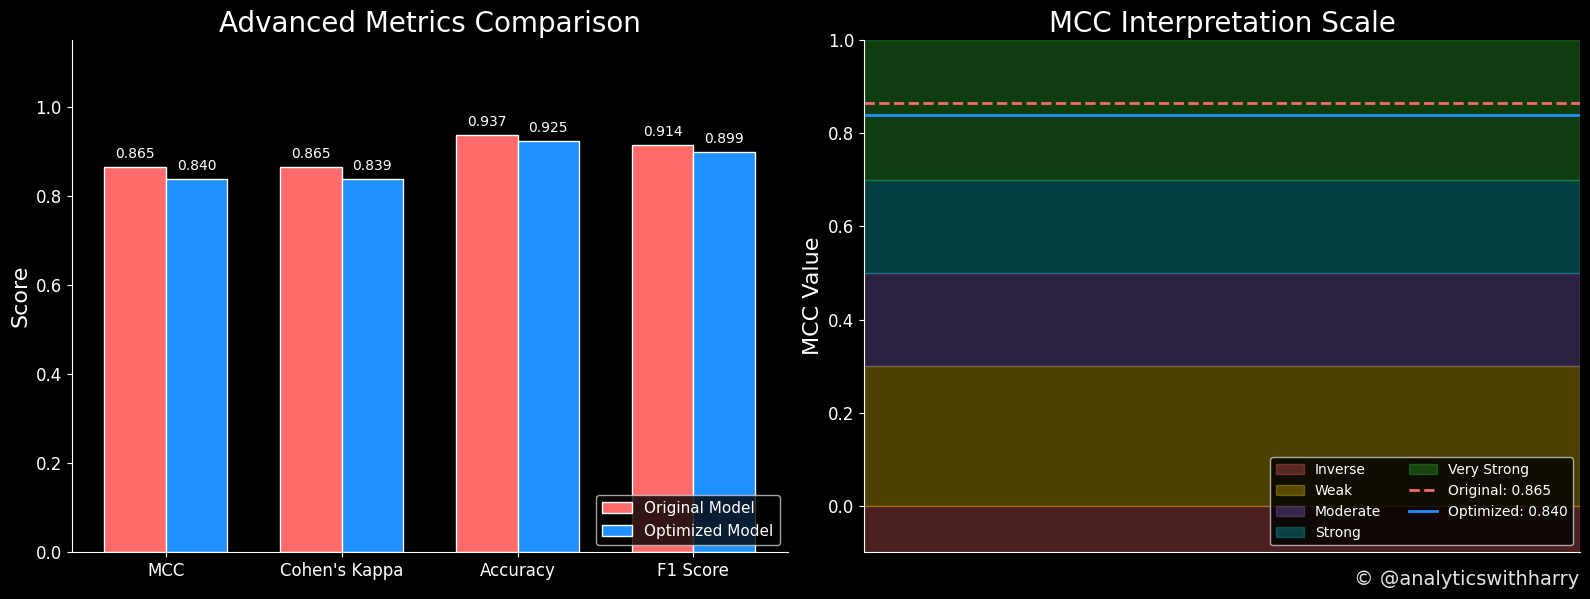


Advanced Metrics Summary:
Metric                      Original       Optimized
------------------------------------------------------------
MCC                           0.8649          0.8395
Cohen's Kappa                 0.8648          0.8393
Accuracy                      0.9373          0.9248
F1 Score                      0.9141          0.8993

MCC Interpretation: Very Strong correlation (0.840)
MCC Improvement: -0.0254


In [81]:
advanced_metrics_summary = plot_advanced_metrics(y_test, base_test_predictions, tuned_test_predictions)

## Step 29: Prediction Confidence Analysis

This step examines how confident the model is in its predictions. We analyze the distribution of confidence scores for correct vs incorrect predictions, and explore whether the model is more confident on certain types of samples. A well-calibrated model should be highly confident when correct and less confident when uncertain.

In [82]:
# this function slices performance by confidence zones
def analyze_prediction_confidence(X_test, y_test, predictions, probas):
    if probas is None:
        raise ValueError("Prediction probabilities required for confidence analysis")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    confidence = np.where(predictions == 1, probas, 1 - probas)
    axes[0, 0].hist(confidence[y_test == 0], bins=20, alpha=0.7, label="Not Purchased", color=SECONDARY_COLOR, edgecolor="white")
    axes[0, 0].hist(confidence[y_test == 1], bins=20, alpha=0.7, label="Purchased", color=PRIMARY_COLOR, edgecolor="white")
    axes[0, 0].set_xlabel("Prediction Confidence", fontsize=14, color="white")
    axes[0, 0].set_ylabel("Count", fontsize=14, color="white")
    axes[0, 0].set_title("Confidence Distribution by True Class", fontsize=16, color="white")
    axes[0, 0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].spines["top"].set_visible(False)
    axes[0, 0].spines["right"].set_visible(False)
    correct_confidence = confidence[predictions == y_test]
    incorrect_confidence = confidence[predictions != y_test]
    bp = axes[0, 1].boxplot([correct_confidence, incorrect_confidence], labels=["Correct", "Incorrect"], patch_artist=True)
    bp['boxes'][0].set_facecolor(SUCCESS_COLOR)
    bp['boxes'][1].set_facecolor(ACCENT_COLOR)
    for element in ['whiskers', 'caps', 'medians']:
        for line in bp[element]:
            line.set_color('white')
    axes[0, 1].set_ylabel('Confidence', fontsize=14, color='white')
    axes[0, 1].set_title('Confidence: Correct vs Incorrect Predictions', fontsize=16, color='white')
    axes[0, 1].tick_params(axis='both', labelcolor='white', labelsize=12)
    axes[0, 1].spines['top'].set_visible(False)
    axes[0, 1].spines['right'].set_visible(False)
    from scipy.ndimage import gaussian_filter1d
    hist_0, bin_edges = np.histogram(probas[y_test == 0], bins=30, density=True)
    hist_1, _ = np.histogram(probas[y_test == 1], bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    axes[1, 0].fill_between(bin_centers, gaussian_filter1d(hist_0, sigma=1), alpha=0.5, color=SECONDARY_COLOR, label="Not Purchased")
    axes[1, 0].fill_between(bin_centers, gaussian_filter1d(hist_1, sigma=1), alpha=0.5, color=PRIMARY_COLOR, label="Purchased")
    axes[1, 0].axvline(x=0.5, color=ACCENT_COLOR, linestyle="--", lw=2, label="Threshold")
    axes[1, 0].set_xlabel("Predicted Probability", fontsize=14, color="white")
    axes[1, 0].set_ylabel("Density", fontsize=14, color="white")
    axes[1, 0].set_title("Probability Density by Class", fontsize=16, color="white")
    axes[1, 0].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].spines["top"].set_visible(False)
    axes[1, 0].spines["right"].set_visible(False)
    low_conf_mask = (probas > 0.3) & (probas < 0.7)
    high_conf_mask = ~low_conf_mask
    low_conf_accuracy = accuracy_score(y_test[low_conf_mask], predictions[low_conf_mask]) if np.sum(low_conf_mask) > 0 else 0
    high_conf_accuracy = accuracy_score(y_test[high_conf_mask], predictions[high_conf_mask]) if np.sum(high_conf_mask) > 0 else 0
    zone_labels = ["Low Confidence\n(0.3-0.7)", "High Confidence\n(<0.3 or >0.7)"]
    zone_accuracies = [low_conf_accuracy * 100, high_conf_accuracy * 100]
    zone_counts = [np.sum(low_conf_mask), np.sum(high_conf_mask)]
    zone_colors = [WARNING_COLOR, SUCCESS_COLOR]
    bars = axes[1, 1].bar(range(len(zone_labels)), zone_accuracies, color=zone_colors, edgecolor="white", width=0.6)
    axes[1, 1].set_xticks(range(len(zone_labels)))
    axes[1, 1].set_xticklabels(zone_labels, fontsize=12)
    axes[1, 1].set_ylabel("Accuracy (%)", fontsize=14, color="white")
    axes[1, 1].set_title("Accuracy by Confidence Zone", fontsize=16, color="white")
    axes[1, 1].tick_params(axis="both", labelcolor="white", labelsize=12)
    axes[1, 1].spines["top"].set_visible(False)
    axes[1, 1].spines["right"].set_visible(False)
    axes[1, 1].set_ylim([0, 110])
    for bar, acc, cnt in zip(bars, zone_accuracies, zone_counts):
        axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, "{:.1f}%\n(n={})".format(acc, cnt), ha="center", color="white", fontsize=11)
    plt.figtext(0.99, 0.0001, COPYRIGHT_TEXT, ha="right", va="bottom", fontsize=14, color="white", alpha=0.9)
    fig.tight_layout()
    plt.show()
    print("\nConfidence Analysis Summary:")
    print("=" * 50)
    print("Mean Confidence (Correct):   {:.4f}".format(np.mean(correct_confidence)))
    print("Mean Confidence (Incorrect): {:.4f}".format(np.mean(incorrect_confidence) if len(incorrect_confidence) > 0 else 0))
    print("\nLow Confidence Zone:  {} samples ({:.1f}% accuracy)".format(np.sum(low_conf_mask), low_conf_accuracy * 100))
    print("High Confidence Zone: {} samples ({:.1f}% accuracy)".format(np.sum(high_conf_mask), high_conf_accuracy * 100))
    return {
        "figure": fig,
        "low_conf_accuracy": low_conf_accuracy,
        "high_conf_accuracy": high_conf_accuracy,
    }

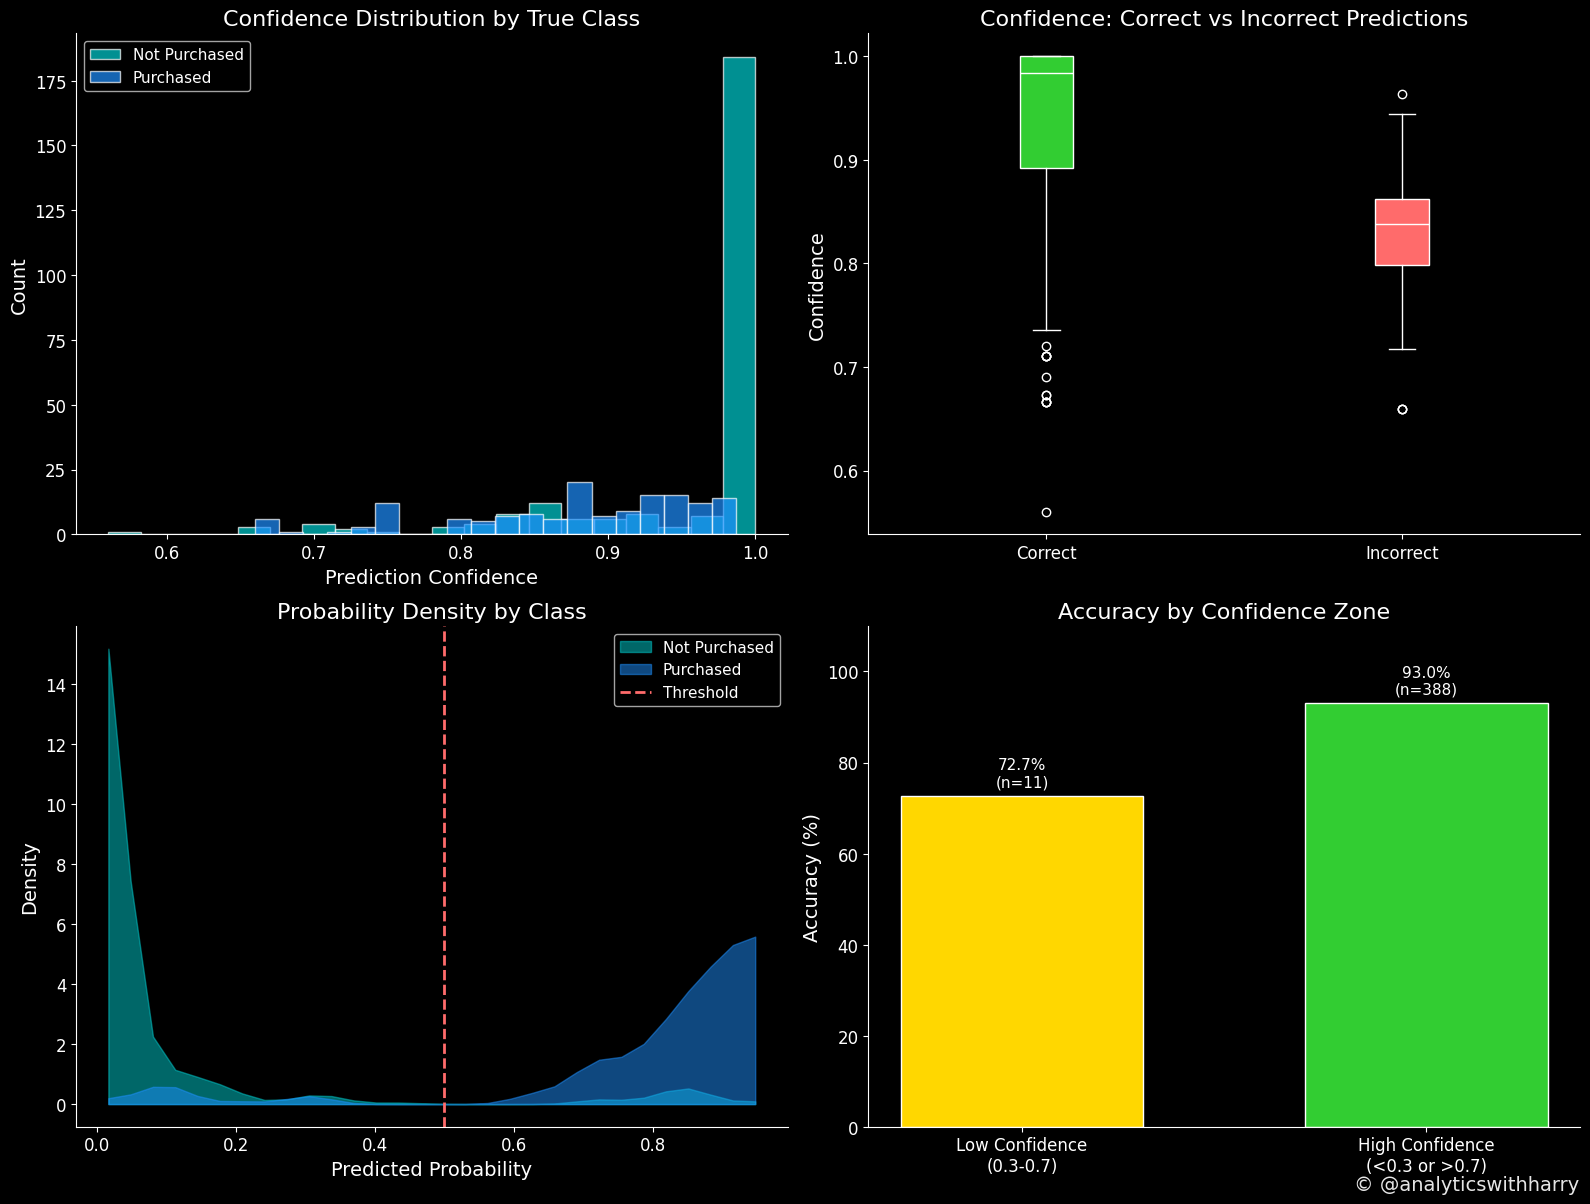


Confidence Analysis Summary:
Mean Confidence (Correct):   0.9369
Mean Confidence (Incorrect): 0.8215

Low Confidence Zone:  11 samples (72.7% accuracy)
High Confidence Zone: 388 samples (93.0% accuracy)


In [83]:
confidence_summary = analyze_prediction_confidence(X_test, y_test, tuned_test_predictions, tuned_test_probabilities)

## Step 30: Final Summary Report

This final step compiles all the key findings from our neural network analysis into a comprehensive report. It summarizes the dataset, model architecture, performance metrics, and improvement achieved through hyperparameter tuning.

In [84]:
# this function assembles the final text summary
def final_summary_report(y, y_train, y_test, feature_names, base_preds, tuned_preds, base_proba, tuned_proba, best_config, calibration_info, optimal_threshold, most_important_feature, learning_curve_info, rates):
    print("=" * 80)
    print("               COMPREHENSIVE NEURAL NETWORK ANALYSIS REPORT")
    print("=" * 80)
    print("\nDATASET OVERVIEW")
    print("-" * 40)
    print("Total Samples:     {}".format(len(y)))
    print("Training Samples:  {} ({:.0f}%)".format(len(y_train), len(y_train) / len(y) * 100))
    print("Test Samples:      {} ({:.0f}%)".format(len(y_test), len(y_test) / len(y) * 100))
    print("Features:          {}".format(", ".join(feature_names)))
    print("Target:            Purchase (Binary)")
    print("\nMODEL ARCHITECTURE")
    print("-" * 40)
    print("Base Model:        (128, 64, 32, 16) hidden layers")
    print("Tuned Model:       {} hidden layers".format(best_config["architecture"]))
    print("Activation:        ReLU (hidden), Sigmoid (output)")
    print("Optimizer:         Adam")
    print("Learning Rate:     {}".format(best_config["learning_rate"]))
    print("Max Iterations:    10000")
    print("\nPERFORMANCE METRICS")
    print("-" * 40)
    print("{:20s} {:>12s} {:>12s}".format("Metric", "Base", "Tuned"))
    print("-" * 44)
    print("{:20s} {:>12.2f}% {:>12.2f}%".format("Accuracy", accuracy_score(y_test, base_preds) * 100, accuracy_score(y_test, tuned_preds) * 100))
    print("{:20s} {:>12.2f}% {:>12.2f}%".format("Precision", precision_score(y_test, base_preds) * 100, precision_score(y_test, tuned_preds) * 100))
    print("{:20s} {:>12.2f}% {:>12.2f}%".format("Recall", recall_score(y_test, base_preds) * 100, recall_score(y_test, tuned_preds) * 100))
    print("{:20s} {:>12.2f}% {:>12.2f}%".format("F1 Score", f1_score(y_test, base_preds) * 100, f1_score(y_test, tuned_preds) * 100))
    if base_proba is not None and tuned_proba is not None:
        print("{:20s} {:>12.4f} {:>12.4f}".format("AUC-ROC", roc_auc_score(y_test, base_proba), roc_auc_score(y_test, tuned_proba)))
    base_mcc = matthews_corrcoef_custom(y_test, base_preds)
    tuned_mcc = matthews_corrcoef_custom(y_test, tuned_preds)
    base_kappa = cohens_kappa_custom(y_test, base_preds)
    tuned_kappa = cohens_kappa_custom(y_test, tuned_preds)
    print("{:20s} {:>12.4f} {:>12.4f}".format("MCC", base_mcc, tuned_mcc))
    print("{:20s} {:>12.4f} {:>12.4f}".format("Cohen's Kappa", base_kappa, tuned_kappa))
    print("\nADVANCED ANALYSIS INSIGHTS")
    print("-" * 40)
    print("Calibration Error (ECE):     {:.4f}".format(calibration_info["ece"]))
    print("Optimal Threshold:           {:.2f}".format(optimal_threshold))
    print("Most Important Feature:      {}".format(most_important_feature))
    if learning_curve_info["final_train_accuracy"] is not None:
        print("Generalization Gap:          {:.2f}%".format((learning_curve_info["final_train_accuracy"] - learning_curve_info["final_test_accuracy"]) * 100))
    print("Sensitivity (TPR):           {:.2f}%".format(rates["sensitivity"] * 100))
    print("Specificity (TNR):           {:.2f}%".format(rates["specificity"] * 100))
    print("\nIMPROVEMENT SUMMARY")
    print("-" * 40)
    acc_improvement = (accuracy_score(y_test, tuned_preds) - accuracy_score(y_test, base_preds)) * 100
    f1_improvement = (f1_score(y_test, tuned_preds) - f1_score(y_test, base_preds)) * 100
    mcc_improvement = tuned_mcc - base_mcc
    print("Accuracy Improvement:  {:+.2f}%".format(acc_improvement))
    print("F1 Score Improvement:  {:+.2f}%".format(f1_improvement))
    print("MCC Improvement:       {:+.4f}".format(mcc_improvement))
    print("\n" + "=" * 80)
    print("Analysis complete! Neural network successfully trained and evaluated.")
    print("=" * 80)
    print("\n" + COPYRIGHT_TEXT)

In [85]:
final_report = final_summary_report(
    y_raw,
    y_train,
    y_test,
    feature_names,
    base_test_predictions,
    tuned_test_predictions,
    base_test_probabilities,
    tuned_test_probabilities,
    hyperparameter_summary["best_config"],
    calibration_summary,
    precision_recall_summary["optimal_threshold"],
    feature_importance_summary["most_important"],
    learning_curve_summary,
    error_dashboard["rates"],
)

               COMPREHENSIVE NEURAL NETWORK ANALYSIS REPORT

DATASET OVERVIEW
----------------------------------------
Total Samples:     2000
Training Samples:  1601 (80%)
Test Samples:      399 (20%)
Features:          Age, EstimatedSalary
Target:            Purchase (Binary)

MODEL ARCHITECTURE
----------------------------------------
Base Model:        (128, 64, 32, 16) hidden layers
Tuned Model:       (128, 64, 32) hidden layers
Activation:        ReLU (hidden), Sigmoid (output)
Optimizer:         Adam
Learning Rate:     0.01
Max Iterations:    10000

PERFORMANCE METRICS
----------------------------------------
Metric                       Base        Tuned
--------------------------------------------
Accuracy                    93.73%        92.48%
Precision                   92.36%        88.74%
Recall                      90.48%        91.16%
F1 Score                    91.41%        89.93%
AUC-ROC                    0.9884       0.9720
MCC                        0.8649       0